Context-Engineering: 用于结构化推理的提示程序
============================================================

本模块介绍提示编程：一种结构化的方法，将提示设计为具有组合操作、状态管理和控制流的可执行程序。通过将提示视为类似代码的实体，我们可以创建更健壮、透明且可扩展的推理系统。

涵盖的关键概念：
1. 基本提示程序结构和模板
2. 组合操作（推理步骤、验证、综合）
3. 作为提示程序的协议外壳和框架
4. 用于涌现推理的领域协议和框架
5. 用于自我改进提示程序的高级模式

用法：
    # 在 Jupyter 或 Colab 中：
    %run 05_prompt_programs.py
    # 或者
    from prompt_programs import PromptProgram, ReasoningProtocol, FieldShell


In [1]:
import os
import re
import json
import time
import logging
import hashlib
import tiktoken
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Any, Optional, Union, Callable, TypeVar
from IPython.display import display, Markdown, HTML

# 配置日志记录
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# 检查所需库
try:
    from openai import OpenAI
    OPENAI_AVAILABLE = True
except ImportError:
    OPENAI_AVAILABLE = False
    logger.warning("未找到 OpenAI 包。请使用：pip install openai 安装")

try:
    import dotenv
    dotenv.load_dotenv()
    ENV_LOADED = True
except ImportError:
    ENV_LOADED = False
    logger.warning("未找到 python-dotenv。请使用：pip install python-dotenv 安装")

# 常量
DEFAULT_MODEL = "openai/gpt-4.1"
DEFAULT_TEMPERATURE = 0.7
DEFAULT_MAX_TOKENS = 1000


# 辅助函数
# ===============

def setup_client(api_key=None, model=DEFAULT_MODEL):
    """
    设置用于 LLM 交互的 API 客户端。

    参数：
        api_key: API 密钥（如果为 None，将在环境变量中查找 OPENAI_API_KEY）
        model: 要使用的模型名称

    返回：
        tuple: (客户端, 模型名称)
    """
    if api_key is None:
        api_key = os.environ.get("GITHUB_TOKEN")
        if api_key is None and not ENV_LOADED:
            logger.warning("未找到 API 密钥。请设置 OPENAI_API_KEY 环境变量或传递 api_key 参数。")
    
    if OPENAI_AVAILABLE:
        client = OpenAI(
            base_url="https://models.github.ai/inference",
            api_key=api_key,
        )
        return client, model
    else:
        logger.error("需要 OpenAI 包。请安装：pip install openai")
        return None, model


def count_tokens(text: str, model: str = DEFAULT_MODEL) -> int:
    """
    使用适当的分词器统计文本字符串中的 token 数量。

    参数：
        text: 要分词的文本
        model: 用于分词的模型名称

    返回：
        int: token 数量
    """
    try:
        encoding = tiktoken.get_encoding("cl100k_base")
        return len(encoding.encode(text))
    except Exception as e:
        # 当 tiktoken 不支持该模型时的备用方案
        logger.warning(f"无法为 {model} 使用 tiktoken: {e}")
        # 粗略估算：英文中 1 个 token ≈ 4 个字符
        return len(text) // 4


def generate_response(
    prompt: str,
    client=None,
    model: str = DEFAULT_MODEL,
    temperature: float = DEFAULT_TEMPERATURE,
    max_tokens: int = DEFAULT_MAX_TOKENS,
    system_message: str = "你是一个乐于助人的助手。"
) -> Tuple[str, Dict[str, Any]]:
    """
    从 LLM 生成响应并返回元数据。

    参数：
        prompt: 要发送的提示
        client: API 客户端（如果为 None，则会创建一个）
        model: 模型名称
        temperature: 温度参数
        max_tokens: 最大生成 token 数量
        system_message: 系统消息

    返回：
        tuple: (响应文本, 元数据)
    """
    if client is None:
        client, model = setup_client(model=model)
        if client is None:
            return "错误：没有可用的 API 客户端", {"error": "没有 API 客户端"}
    
    prompt_tokens = count_tokens(prompt, model)
    system_tokens = count_tokens(system_message, model)
    
    metadata = {
        "prompt_tokens": prompt_tokens,
        "system_tokens": system_tokens,
        "model": model,
        "temperature": temperature,
        "max_tokens": max_tokens,
        "timestamp": time.time()
    }
    
    try:
        start_time = time.time()
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_message},
                {"role": "user", "content": prompt}
            ],
            temperature=temperature,
            max_tokens=max_tokens
        )
        latency = time.time() - start_time
        
        response_text = response.choices[0].message.content
        response_tokens = count_tokens(response_text, model)
        
        metadata.update({
            "latency": latency,
            "response_tokens": response_tokens,
            "total_tokens": prompt_tokens + system_tokens + response_tokens,
            "token_efficiency": response_tokens / (prompt_tokens + system_tokens) if (prompt_tokens + system_tokens) > 0 else 0,
            "tokens_per_second": response_tokens / latency if latency > 0 else 0
        })
        
        return response_text, metadata
    
    except Exception as e:
        logger.error(f"生成响应时出错: {e}")
        metadata["error"] = str(e)
        return f"错误：{str(e)}", metadata


def format_metrics(metrics: Dict[str, Any]) -> str:
    """
    将指标字典格式化为可读字符串。
    
    参数：
        metrics: 指标字典
        
    返回：
        str: 格式化后的指标字符串
    """
    # 选择最重要的指标进行展示
    key_metrics = {
        "prompt_tokens": metrics.get("prompt_tokens", 0),
        "response_tokens": metrics.get("response_tokens", 0),
        "total_tokens": metrics.get("total_tokens", 0),
        "latency": f"{metrics.get('latency', 0):.2f}秒",
        "token_efficiency": f"{metrics.get('token_efficiency', 0):.2f}"
    }
    
    return " | ".join([f"{k}: {v}" for k, v in key_metrics.items()])


def display_program_output(
    program_name: str,
    input_data: Any,
    output_data: Any,
    state_history: Optional[List[Dict[str, Any]]] = None,
    metrics: Optional[Dict[str, Any]] = None
) -> None:
    """
    在笔记本中展示提示程序的执行结果。
    
    参数：
        program_name: 提示程序名称
        input_data: 输入数据
        output_data: 输出数据
        state_history: 程序执行状态历史（可选）
        metrics: 指标字典（可选）
    """
    display(HTML(f"<h2>提示程序：{program_name}</h2>"))
    
    # 展示输入
    display(HTML("<h3>输入</h3>"))
    if isinstance(input_data, str):
        display(Markdown(input_data))
    else:
        display(Markdown(f"```json\n{json.dumps(input_data, indent=2)}\n```"))
    
    # 展示执行状态历史
    if state_history:
        display(HTML("<h3>执行历史</h3>"))
        
        for i, state in enumerate(state_history):
            display(HTML(f"<h4>步骤 {i+1}: {state.get('operation', '执行')}</h4>"))
            
            # 展示提示内容（如果有）
            if "prompt" in state:
                display(HTML("<p><em>提示：</em></p>"))
                display(Markdown(f"```\n{state['prompt']}\n```"))
            
            # 展示响应内容（如果有）
            if "response" in state:
                display(HTML("<p><em>响应：</em></p>"))
                display(Markdown(state["response"]))
            
            # 展示状态指标（如果有）
            if "metrics" in state:
                display(HTML("<p><em>指标：</em></p>"))
                display(Markdown(f"```\n{format_metrics(state['metrics'])}\n```"))
    
    # 展示输出
    display(HTML("<h3>输出</h3>"))
    if isinstance(output_data, str):
        display(Markdown(output_data))
    else:
        display(Markdown(f"```json\n{json.dumps(output_data, indent=2)}\n```"))
    
    # 展示总体指标
    if metrics:
        display(HTML("<h3>总体指标</h3>"))
        display(Markdown(f"```\n{format_metrics(metrics)}\n```"))


In [3]:
# 提示程序的基类
# ===============================

@dataclass
class PromptTemplate:
    """
    一个带有变量的提示模板，可以填充变量。
    """
    template: str
    variables: List[str] = field(default_factory=list)
    
    def __post_init__(self):
        """初始化时从模板中提取变量（如果未提供）。"""
        if not self.variables:
            # 从模板中的 {变量} 模式提取变量
            import re
            self.variables = re.findall(r'\{([^{}]*)\}', self.template)
    
    def format(self, **kwargs) -> str:
        """
        Format the template with the provided variables.
        
        Args:
            **kwargs: Variable values to fill in
            
        Returns:
            str: Formatted prompt
        """
        # Check for missing variables
        missing_vars = [var for var in self.variables if var not in kwargs]
        if missing_vars:
            raise ValueError(f"Missing variables: {', '.join(missing_vars)}")
        
        # Format the template
        return self.template.format(**kwargs)


class PromptProgram:
    """
    提示程序的基类——可以作为具有状态和操作的程序执行的结构化提示。
    """
    
    def __init__(
        self,
        name: str,
        description: str = "",
        client=None,
        model: str = DEFAULT_MODEL,
        system_message: str = "你是一个乐于助人的助手。",
        max_tokens: int = DEFAULT_MAX_TOKENS,
        temperature: float = DEFAULT_TEMPERATURE,
        verbose: bool = False
    ):
        """
        初始化提示程序。
        
        参数:
            name: 程序名称
            description: 程序描述
            client: API 客户端（如果为 None，则会创建一个）
            model: 使用的模型名称
            system_message: 使用的系统消息
            max_tokens: 生成的最大 token 数
            temperature: 温度参数
            verbose: 是否打印调试信息
        """
        self.name = name
        self.description = description
        self.client, self.model = setup_client(model=model) if client is None else (client, model)
        self.system_message = system_message
        self.max_tokens = max_tokens
        self.temperature = temperature
        self.verbose = verbose
        
        # 初始化状态
        self.state = {}
        self.state_history = []
        
        # 初始化指标跟踪
        self.metrics = {
            "total_prompt_tokens": 0,
            "total_response_tokens": 0,
            "total_tokens": 0,
            "total_latency": 0,
            "steps": 0
        }
    
    def _log(self, message: str) -> None:
        """
        如果启用 verbose 模式，则记录消息。
        
        参数:
            message: 要记录的消息
        """
        if self.verbose:
            logger.info(message)
    
    def _generate_prompt(self, **kwargs) -> str:
        """
        为当前操作生成提示。
        
        参数:
            **kwargs: 提示模板的变量
            
        返回:
            str: 生成的提示
        """
        # 这是一个占位符——子类应实现此方法
        raise NotImplementedError("子类必须实现 _generate_prompt")
    
    def _call_llm(
        self,
        prompt: str,
        custom_system_message: Optional[str] = None
    ) -> Tuple[str, Dict[str, Any]]:
        """
        调用 LLM 并更新指标。
        
        参数:
            prompt: 要发送的提示
            custom_system_message: 覆盖系统消息（可选）
            
        返回:
            tuple: (响应文本, 元数据)
        """
        system_msg = custom_system_message if custom_system_message else self.system_message
        
        response, metadata = generate_response(
            prompt=prompt,
            client=self.client,
            model=self.model,
            temperature=self.temperature,
            max_tokens=self.max_tokens,
            system_message=system_msg
        )
        
        # 更新指标
        self.metrics["total_prompt_tokens"] += metadata.get("prompt_tokens", 0)
        self.metrics["total_response_tokens"] += metadata.get("response_tokens", 0)
        self.metrics["total_tokens"] += metadata.get("total_tokens", 0)
        self.metrics["total_latency"] += metadata.get("latency", 0)
        self.metrics["steps"] += 1
        
        return response, metadata
    
    def _process_response(self, response: str) -> Any:
        """
        将 LLM 响应处理为结构化输出。
        
        参数:
            response: LLM 响应文本
            
        返回:
            Any: 处理后的输出
        """
        # 默认实现直接返回响应
        return response
    
    def _update_state(
        self,
        operation: str,
        prompt: str,
        response: str,
        metrics: Dict[str, Any],
        processed_output: Any
    ) -> None:
        """
        用最新的操作结果更新程序状态。
        
        参数:
            operation: 操作名称
            prompt: 发送给 LLM 的提示
            response: 原始 LLM 响应
            metrics: 操作指标
            processed_output: 处理后的操作输出
        """
        # 创建状态记录
        state_record = {
            "operation": operation,
            "prompt": prompt,
            "response": response,
            "metrics": metrics,
            "output": processed_output,
            "timestamp": time.time()
        }
        
        # 添加到状态历史
        self.state_history.append(state_record)
        
        # 更新当前状态
        self.state["last_operation"] = operation
        self.state["last_prompt"] = prompt
        self.state["last_response"] = response
        self.state["last_output"] = processed_output
        self.state["current_step"] = len(self.state_history)
    
    def execute(self, input_data: Any) -> Any:
        """
        使用给定输入执行提示程序。
        
        参数:
            input_data: 程序的输入数据
            
        返回:
            Any: 程序输出
        """
        # 用输入初始化状态
        self.state = {"input": input_data}
        self.state_history = []
        
        self._log(f"执行提示程序: {self.name}")
        
        # 生成提示
        prompt = self._generate_prompt(input=input_data)
        
        # 调用 LLM
        response, metrics = self._call_llm(prompt)
        
        # 处理响应
        output = self._process_response(response)
        
        # 更新状态
        self._update_state("execute", prompt, response, metrics, output)
        
        return output
    
    def get_summary_metrics(self) -> Dict[str, Any]:
        """
        获取所有操作的汇总指标。
        
        返回:
            dict: 汇总指标
        """
        summary = self.metrics.copy()
        
        # 添加派生指标
        if summary["steps"] > 0:
            summary["avg_latency_per_step"] = summary["total_latency"] / summary["steps"]
            
        if summary["total_prompt_tokens"] > 0:
            summary["overall_efficiency"] = (
                summary["total_response_tokens"] / summary["total_prompt_tokens"]
            )
        
        return summary
    
    def display_execution(self) -> None:
        """在 notebook 中显示程序执行结果。"""
        display_program_output(
            program_name=self.name,
            input_data=self.state.get("input"),
            output_data=self.state.get("last_output"),
            state_history=self.state_history,
            metrics=self.get_summary_metrics()
        )
    
    def visualize_metrics(self) -> None:
        """
        创建跨执行步骤的指标可视化。
        """
        if not self.state_history:
            logger.warning("没有可视化的执行历史")
            return
        
        # 提取用于绘图的数据
        steps = list(range(1, len(self.state_history) + 1))
        prompt_tokens = [h["metrics"].get("prompt_tokens", 0) for h in self.state_history]
        response_tokens = [h["metrics"].get("response_tokens", 0) for h in self.state_history]
        latencies = [h["metrics"].get("latency", 0) for h in self.state_history]
        efficiencies = [h["metrics"].get("token_efficiency", 0) for h in self.state_history]
        
        # 创建图形
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle(f"提示程序指标: {self.name}", fontsize=16)

        plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
        plt.rcParams['axes.unicode_minus'] = False

        # 图1: Token 使用情况
        axes[0, 0].bar(steps, prompt_tokens, label="提示 Token", color="blue", alpha=0.7)
        axes[0, 0].bar(steps, response_tokens, bottom=prompt_tokens, label="响应 Token", 
                       color="green", alpha=0.7)
        axes[0, 0].set_title("Token 使用情况")
        axes[0, 0].set_xlabel("步骤")
        axes[0, 0].set_ylabel("Token 数")
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)
        
        # 图2: 延迟
        axes[0, 1].plot(steps, latencies, marker='o', color="red", alpha=0.7)
        axes[0, 1].set_title("延迟")
        axes[0, 1].set_xlabel("步骤")
        axes[0, 1].set_ylabel("秒")
        axes[0, 1].grid(alpha=0.3)
        
        # 图3: Token 效率
        axes[1, 0].plot(steps, efficiencies, marker='s', color="purple", alpha=0.7)
        axes[1, 0].set_title("Token 效率 (响应/提示)")
        axes[1, 0].set_xlabel("步骤")
        axes[1, 0].set_ylabel("比率")
        axes[1, 0].grid(alpha=0.3)
        
        # 图4: 累计 Token
        cumulative_tokens = np.cumsum([h["metrics"].get("total_tokens", 0) for h in self.state_history])
        axes[1, 1].plot(steps, cumulative_tokens, marker='^', color="orange", alpha=0.7)
        axes[1, 1].set_title("累计 Token 使用")
        axes[1, 1].set_xlabel("步骤")
        axes[1, 1].set_ylabel("总 Token 数")
        axes[1, 1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()


class MultiStepProgram(PromptProgram):
    """
    一个可以按顺序执行多个操作的提示程序。
    """
    
    def __init__(
        self,
        operations: List[Dict[str, Any]] = None,
        **kwargs
    ):
        """
        初始化多步骤提示程序。
        
        参数:
            operations: 操作配置列表
            **kwargs: 传递给 PromptProgram 的其他参数
        """
        super().__init__(**kwargs)
        self.operations = operations or []
    
    def add_operation(
        self,
        name: str,
        prompt_template: str,
        system_message: Optional[str] = None,
        output_processor: Optional[Callable[[str], Any]] = None
    ) -> None:
        """
        向程序添加一个操作。
        
        参数:
            name: 操作名称
            prompt_template: 操作提示模板
            system_message: 自定义系统消息（可选）
            output_processor: 处理操作输出的函数（可选）
        """
        operation = {
            "name": name,
            "prompt_template": PromptTemplate(prompt_template),
            "system_message": system_message,
            "output_processor": output_processor
        }
        
        self.operations.append(operation)
    
    def execute(self, input_data: Any) -> Any:
        """
        按顺序执行所有操作。
        
        参数:
            input_data: 程序的输入数据
            
        返回:
            Any: 最终程序输出
        """
        # 用输入初始化状态
        self.state = {"input": input_data}
        self.state_history = []
        
        self._log(f"执行多步骤提示程序: {self.name}")
        
        # 依次处理每个操作
        current_input = input_data
        original_problem = input_data  # 保存原始问题
        original_solution = None  # 保存原始解决方案
        
        for i, operation in enumerate(self.operations):
            operation_name = operation["name"]
            self._log(f"执行操作 {i+1}/{len(self.operations)}: {operation_name}")
            
            # 生成提示
            prompt_template = operation["prompt_template"]
            
            # 准备格式化变量
            prompt_vars = {
                "input": current_input,
                "original_problem": original_problem,
                "original_solution": original_solution,
                **self.state
            }
            
            # 只传递模板实际需要的变量
            required_vars = {}
            for var in prompt_template.variables:
                if var in prompt_vars:
                    required_vars[var] = prompt_vars[var]
                else:
                    # 如果变量不存在，使用默认值或跳过
                    if var == "original_solution" and original_solution is None:
                        required_vars[var] = "暂无原始解决方案"
                    else:
                        required_vars[var] = f"[{var}]"
            
            prompt = prompt_template.format(**required_vars)
            
            # 调用 LLM
            system_message = operation.get("system_message")
            response, metrics = self._call_llm(prompt, system_message)
            
            # 处理响应
            output_processor = operation.get("output_processor")
            if output_processor:
                output = output_processor(response)
            else:
                output = response
            
            # 更新状态
            self._update_state(operation_name, prompt, response, metrics, output)
            
            # 保存第一个操作的输出作为原始解决方案
            if i == 0:
                original_solution = output
            
            # 更新下一个操作的输入
            current_input = output
        
        return current_input
    
    def _generate_prompt(self, **kwargs) -> str:
        """MultiStepProgram 不直接使用该方法。"""
        raise NotImplementedError("MultiStepProgram 使用操作专属的提示模板")

In [17]:
# 推理协议程序
# =========================

class ReasoningProtocol(MultiStepProgram):
    """
    一个实现结构化推理协议的提示程序，
    包含明确的推理步骤和验证过程。
    """
    
    def __init__(
        self,
        reasoning_steps: List[str] = None,
        verification_enabled: bool = True,
        **kwargs
    ):
        """
        初始化推理协议。
        
        参数:
            reasoning_steps: 推理步骤描述的列表
            verification_enabled: 是否启用推理验证
            **kwargs: 传递给 MultiStepProgram 的其他参数
        """
        super().__init__(**kwargs)
        
        # 如果未提供推理步骤，则使用默认步骤
        if reasoning_steps is None:
            reasoning_steps = [
                "理解问题",
                "识别关键组成部分",
                "规划解决方案方法",
                "执行解决方案",
                "验证答案"
            ]
        
        self.reasoning_steps = reasoning_steps
        self.verification_enabled = verification_enabled
        
        # 设置操作流程
        self._setup_operations()
    
    def _setup_operations(self) -> None:
        """设置推理协议的标准操作流程。"""
        # 清除已有操作
        self.operations = []
        
        # 添加推理操作
        reasoning_template = self._create_reasoning_template()
        self.add_operation(
            name="reasoning",
            prompt_template=reasoning_template,
            system_message="你是一位专家级问题解决者，善于将问题逐步拆解。",
            output_processor=None  # 使用原始响应
        )
        
        # 如果启用验证，则添加验证操作
        if self.verification_enabled:
            verification_template = self._create_verification_template()
            self.add_operation(
                name="verification",
                prompt_template=verification_template,
                system_message="你是一位严谨的审查者，仔细检查推理过程中的错误。",
                output_processor=None  # 使用原始响应
            )
            
            # 添加修正操作
            correction_template = self._create_correction_template()
            self.add_operation(
                name="correction",
                prompt_template=correction_template,
                system_message="你是一位专家级问题解决者，能够给出正确的解决方案。",
                output_processor=None  # 使用原始响应
            )
    
    def _create_reasoning_template(self) -> str:
        """创建推理操作的模板。"""
        steps_text = "\n".join([f"{i+1}. {step}" for i, step in enumerate(self.reasoning_steps)])
        
        return f"""请按照以下步骤解决问题：

{steps_text}

每一步都要明确说明你的推理过程。请详细且精准地作答。

问题: {{input}}

你的逐步解决方案:
"""
    
    def _create_verification_template(self) -> str:
        """创建验证操作的模板。"""
        return """请审查以下解决方案，查找推理或计算中的任何错误。
如有具体问题请指出，否则请确认该方案正确。

问题: {original_problem}

解决方案:
{input}

你的验证结果:
"""
    
    def _create_correction_template(self) -> str:
        """创建修正操作的模板。"""
        return """请针对已发现的问题，给出该问题的修正解决方案。

问题: {original_problem}

原始解决方案:
{original_solution}

验证发现:
{input}

你的修正解决方案:
"""
    
    def execute(self, problem: str) -> Dict[str, Any]:
        """
        执行推理协议以解决问题。
        
        参数:
            problem: 待解决的问题
            
        返回:
            dict: 包含推理、验证和最终解决方案的结果
        """
        # 执行多步流程
        final_output = super().execute(problem)
        
        # 整理结果
        results = {
            "problem": problem,
            "reasoning": self.state_history[0]["output"] if len(self.state_history) > 0 else None,
            "verification": self.state_history[1]["output"] if len(self.state_history) > 1 else None,
            "final_solution": final_output
        }
        
        return results


class StepByStepReasoning(ReasoningProtocol):
    """
    一个专注于详细逐步问题解决的推理协议，
    特别适用于数学或逻辑问题。
    """
    
    def __init__(self, **kwargs):
        """初始化逐步推理协议。"""
        # 定义专用推理步骤
        reasoning_steps = [
            "理解问题并识别未知量",
            "列出所有已知信息和约束条件",
            "回忆相关公式或方法",
            "制定逐步解决方案计划",
            "仔细执行每一步，展示所有过程",
            "将答案与原始问题进行核对"
        ]
        
        # 使用专用推理步骤初始化
        super().__init__(reasoning_steps=reasoning_steps, **kwargs)
        
        # 使用更具体的系统提示
        self.system_message = """你是一位擅长系统化、逐步解决复杂问题的专家。
你会清晰展示所有推理过程，明确定义变量，并确保每一步都逻辑严密地衔接上一环节。"""
    
    def _create_reasoning_template(self) -> str:
        """创建数学推理专用模板。"""
        steps_text = "\n".join([f"{i+1}. {step}" for i, step in enumerate(self.reasoning_steps)])
        
        return f"""请逐步解决以下问题，清晰展示你的所有推理过程。
每一步请：
- 解释你的推理
- 明确你引入的变量或符号
- 显示所有计算过程
- 说明每一步与整体方案的关系

请按照以下步骤进行解答：
{steps_text}

问题：{{input}}

你的详细逐步解决方案：
"""


class ComparativeAnalysis(ReasoningProtocol):
    """
    一个专注于比较多个选项、观点或方法，并评估其优缺点的推理协议。
    """
    
    def __init__(self, criteria: List[str] = None, **kwargs):
        """
        初始化比较分析协议。
        
        参数:
            criteria: 评估标准列表（可选）
            **kwargs: 传递给 ReasoningProtocol 的其他参数
        """
        # 存储比较标准 - 在调用 super().__init__() 之前初始化
        self.criteria = criteria or []
        
        # 定义专用推理步骤
        reasoning_steps = [
            "定义需要比较的实体或选项",
            "建立明确的比较标准",
            "根据标准分析每个实体",
            "识别关键的相似点和差异",
            "评估各自的优势与劣势",
            "综合分析并得出结论"
        ]
        
        # 使用专用推理步骤初始化
        super().__init__(reasoning_steps=reasoning_steps, **kwargs)
        
        # 使用更具体的系统提示
        self.system_message = """你是一位擅长比较分析的专家。
你会根据明确标准系统地评估多个实体、选项或方法，
识别相似性与差异，并得出有洞察力的结论。"""
    
    def _create_reasoning_template(self) -> str:
        """创建比较分析专用模板。"""
        steps_text = "\n".join([f"{i+1}. {step}" for i, step in enumerate(self.reasoning_steps)])
        
        criteria_text = ""
        if self.criteria:
            criteria_list = "\n".join([f"- {criterion}" for criterion in self.criteria])
            criteria_text = f"""
请在分析中考虑以下标准：
{criteria_list}

如有需要，可补充其他标准以保证分析全面。"""
        
        return f"""请对输入中描述的实体、选项或方法进行全面比较分析。
{criteria_text}

请按照以下步骤进行分析：
{steps_text}

针对每个实体，请给出具体示例和证据以支持你的评价。
请以清晰、结构化的格式呈现你的分析结果，突出关键洞察。

待分析内容：{{input}}

你的比较分析：
"""

In [21]:
# 字段协议 Shell 实现
# ================================

class FieldShell(PromptProgram):
    """
    一个实现字段协议 shell 的提示程序，用于结构化递归推理、状态管理和动态协议适配。
    """
    
    def __init__(
        self,
        shell_name: str,
        intent: str,
        process_steps: List[Dict[str, Any]],
        input_schema: Dict[str, Any] = None,
        output_schema: Dict[str, Any] = None,
        meta: Dict[str, Any] = None,
        **kwargs
    ):
        """
        初始化字段协议 shell。
        
        参数:
            shell_name: shell 的名称
            intent: shell 的目的说明
            process_steps: 流程步骤和操作列表
            input_schema: 预期输入的模式
            output_schema: 预期输出的模式
            meta: shell 的元数据
            **kwargs: 传递给 PromptProgram 的其他参数
        """
        name = f"/field.{shell_name}"
        description = intent
        super().__init__(name=name, description=description, **kwargs)
        
        self.shell_name = shell_name
        self.intent = intent
        self.process_steps = process_steps
        self.input_schema = input_schema or {}
        self.output_schema = output_schema or {}
        self.meta = meta or {
            "version": "1.0.0",
            "agent_signature": "上下文工程",
            "timestamp": time.time()
        }
        
        # 字段协议的系统消息
        self.system_message = """你是一个实现结构化字段协议的高级推理系统。
你会仔细遵循协议中的每一步，跨操作维护状态，
并生成符合指定模式的输出。"""
    
    def _generate_shell_template(self) -> str:
        """为此协议生成 pareto-lang shell 模板。"""
        # 格式化流程步骤
        steps_text = []
        for step in self.process_steps:
            step_name = step.get("name", "process_step")
            step_params = step.get("params", {})
            
            # 格式化参数
            params_text = []
            for k, v in step_params.items():
                if isinstance(v, str):
                    params_text.append(f'{k}="{v}"')
                else:
                    params_text.append(f"{k}={v}")
            
            params_str = ", ".join(params_text) if params_text else ""
            steps_text.append(f"    /{step_name}{{{params_str}}}")
        
        process_text = ",\n".join(steps_text)
        
        # 构建 shell 模板 - 使用占位符避免格式化冲突
        shell_template = f"""/{self.shell_name}{{
    intent="{self.intent}",
    input={{
        {{INPUT_SECTION}}
    }},
    process=[
{process_text}
    ],
    output={{
        {{OUTPUT_SECTION}}
    }},
    meta={{
        version="{self.meta.get('version', '1.0.0')}",
        agent_signature="{self.meta.get('agent_signature', '上下文工程')}",
        timestamp={{TIMESTAMP}}
    }}
}}"""
        
        return shell_template
    
    def _format_input_section(self, input_data: Any) -> str:
        """格式化 shell 模板的输入部分。"""
        if isinstance(input_data, dict):
            input_lines = []
            for k, v in input_data.items():
                if isinstance(v, str):
                    input_lines.append(f'{k}="{v}"')
                else:
                    input_lines.append(f"{k}={v}")
            return ",\n        ".join(input_lines)
        else:
            return f'input_data="{input_data}"'
    
    def _format_output_section(self) -> str:
        """格式化 shell 模板的输出部分。"""
        if self.output_schema:
            output_lines = []
            for k, v in self.output_schema.items():
                output_lines.append(f"{k}=<{v}>")
            return ",\n        ".join(output_lines)
        else:
            return "result=<处理结果>"
    
    def _generate_prompt(self, **kwargs) -> str:
        """生成用于执行字段协议 shell 的提示。"""
        input_data = kwargs.get("input")
        
        # 格式化 shell 模板
        shell_template = self._generate_shell_template()
        
        # 填充输入和输出部分
        input_section = self._format_input_section(input_data)
        output_section = self._format_output_section()
        timestamp = time.time()
        
        # 使用 replace 而不是 format 来避免格式化冲突
        filled_template = shell_template.replace("{INPUT_SECTION}", input_section)
        filled_template = filled_template.replace("{OUTPUT_SECTION}", output_section)
        filled_template = filled_template.replace("{TIMESTAMP}", str(timestamp))
        
        # 创建执行提示
        prompt = f"""请使用提供的输入执行以下字段协议 shell。
对于每个流程步骤，展示你的推理和结果状态。
确保你的最终输出符合 shell 中指定的输出模式。

{filled_template}

协议执行:
"""
        
        return prompt
    
    def _process_response(self, response: str) -> Dict[str, Any]:
        """处理 shell 执行的响应。"""
        # 提取最终输出部分
        output_pattern = r"output\s*=\s*{(.*?)},\s*meta\s*="
        output_match = re.search(output_pattern, response, re.DOTALL)
        
        if output_match:
            output_text = output_match.group(1)
            
            # 解析键值对
            output_dict = {}
            
            # 查找 key=value 模式
            kv_pattern = r'(\w+)\s*=\s*(?:"([^"]*)"|([\w\d\.]+))'
            for match in re.finditer(kv_pattern, output_text):
                key = match.group(1)
                # 值为 group 2（带引号字符串）或 group 3（非引号值）
                value = match.group(2) if match.group(2) is not None else match.group(3)
                output_dict[key] = value
            
            return {
                "shell_output": output_dict,
                "full_execution": response
            }
        else:
            # 如果无法提取结构化输出，则返回完整响应
            return {
                "shell_output": "无法提取结构化输出",
                "full_execution": response
            }


class RecursiveFieldShell(FieldShell):
    """
    一个增强型字段 shell，实现递归字段协议，
    具备自提示、吸引子检测和符号残留跟踪功能。
    """
    
    def __init__(
        self,
        enable_self_prompting: bool = True,
        attractor_detection: bool = True,
        track_residue: bool = True,
        **kwargs
    ):
        """
        初始化递归字段 shell。
        
        参数:
            enable_self_prompting: 是否启用递归自提示
            attractor_detection: 是否检测吸引子模式
            track_residue: 是否跟踪符号残留
            **kwargs: 传递给 FieldShell 的其他参数
        """
        super().__init__(**kwargs)
        
        self.enable_self_prompting = enable_self_prompting
        self.attractor_detection = attractor_detection
        self.track_residue = track_residue
        
        # 为流程步骤添加递归能力
        self._add_recursive_capabilities()
        
        # 递归协议的增强系统消息
        self.system_message = """你是一个实现字段协议的高级递归推理系统，具备涌现智能。
你会跨操作维护状态，检测模式和吸引子，跟踪符号残留，
并可递归自提示以扩展或完善你的推理过程。"""
    
    def _add_recursive_capabilities(self) -> None:
        """为流程步骤添加递归能力。"""
        # 如果启用自提示，则添加自提示步骤
        if self.enable_self_prompting:
            self.process_steps.append({
                "name": "self.prompt",
                "params": {
                    "trigger_condition": "漂移 > 阈值 或 循环完成",
                    "generate_next_protocol": True,
                    "context": "字段状态"
                }
            })
        
        # 如果启用吸引子检测，则在最前面添加吸引子扫描
        if self.attractor_detection:
            self.process_steps.insert(0, {
                "name": "attractor.scan",
                "params": {
                    "detect": "潜在吸引子和涌现模式",
                    "filter_by": "信号强度, 共振",
                    "log_to_audit": True
                }
            })
        
        # 如果启用残留跟踪，则插入残留表面步骤
        if self.track_residue:
            self.process_steps.insert(1, {
                "name": "residue.surface",
                "params": {
                    "mode": "递归",
                    "surface": "符号和概念残留",
                    "integrate_residue": True
                }
            })
            
            # 在最后添加残留压缩
            self.process_steps.append({
                "name": "residue.compress",
                "params": {
                    "compress_residue": True,
                    "resonance_score": "<计算共振(字段状态)>"
                }
            })
    
    def _generate_prompt(self, **kwargs) -> str:
        """生成用于执行递归字段协议 shell 的提示。"""
        prompt = super()._generate_prompt(**kwargs)
        
        # 添加递归执行说明
        recursive_instructions = """
重要提示：这是一个递归字段协议。执行时请注意：
1. 检测输入和中间结果中的涌现模式和吸引子
2. 在流程中表面并整合符号残留
3. 考虑协议本身在执行过程中如何演化
4. 如果被阈值条件触发，为下一轮生成递归自提示

对于每个递归操作，请解释你的推理，包括：
- 你检测到哪些模式或吸引子
- 你表面了哪些符号残留及其整合方式
- 字段状态如何通过递归操作演化
- 何时以及为何触发递归自提示
"""
        
        return prompt + recursive_instructions


In [9]:
# 协议壳实现
# ============================

def create_reasoning_shell() -> RecursiveFieldShell:
    """创建一个逐步推理协议壳。"""
    shell = RecursiveFieldShell(
        shell_name="逐步推理",
        intent="通过结构化、递归推理和明确步骤解决问题",
        process_steps=[
            {
                "name": "问题.分解",
                "params": {
                    "strategy": "识别组成部分、关系和约束"
                }
            },
            {
                "name": "策略.制定",
                "params": {
                    "approach": "递归、逐步解决路径"
                }
            },
            {
                "name": "执行.追踪",
                "params": {
                    "show_work": True,
                    "track_state": True,
                    "enable_backtracking": True
                }
            },
            {
                "name": "解决方案.验证",
                "params": {
                    "check_constraints": True,
                    "validate_logic": True,
                    "assess_efficiency": True
                }
            }
        ],
        input_schema={
            "problem": "问题陈述",
            "context": "附加上下文",
            "constraints": "问题约束"
        },
        output_schema={
            "solution": "最终解决方案",
            "reasoning_trace": "逐步推理过程",
            "verification": "解决方案验证",
            "confidence": "信心评估"
        },
        meta={
            "version": "1.0.0",
            "agent_signature": "上下文工程",
            "protocol_type": "推理"
        },
        verbose=True
    )
    return shell


def create_analysis_shell() -> RecursiveFieldShell:
    """创建一个比较分析协议壳。"""
    shell = RecursiveFieldShell(
        shell_name="比较分析",
        intent="递归分析和比较多个实体、观点或方法",
        process_steps=[
            {
                "name": "实体.识别",
                "params": {
                    "extract": "所有待比较实体",
                    "clarify": "边界和范围"
                }
            },
            {
                "name": "标准.建立",
                "params": {
                    "derive": "根据上下文和目标",
                    "weight": "按相关性和影响加权"
                }
            },
            {
                "name": "分析.执行",
                "params": {
                    "compare": "根据标准比较实体",
                    "highlight": "相似点和不同点",
                    "support": "用证据和示例支持"
                }
            },
            {
                "name": "模式.检测",
                "params": {
                    "identify": "识别反复出现的主题和见解",
                    "surface": "揭示非显性关系"
                }
            },
            {
                "name": "洞见.综合",
                "params": {
                    "integrate": "整合分析结果",
                    "formulate": "形成结论和影响"
                }
            }
        ],
        input_schema={
            "entities": "待比较实体列表",
            "context": "分析上下文",
            "criteria": "可选预定义标准",
            "goals": "分析目标"
        },
        output_schema={
            "comparison_matrix": "实体与标准分析矩阵",
            "key_similarities": "识别的相似点",
            "key_differences": "识别的不同点",
            "patterns": "检测到的模式",
            "insights": "综合洞见",
            "conclusions": "最终结论"
        },
        meta={
            "version": "1.0.0",
            "agent_signature": "上下文工程",
            "protocol_type": "分析"
        },
        verbose=True
    )
    return shell


def create_emergence_shell() -> RecursiveFieldShell:
    """基于字段协议创建递归涌现协议壳。"""
    shell = RecursiveFieldShell(
        shell_name="递归.涌现",
        intent="持续生成递归字段涌现，维持代理性，并实现自主自提示",
        process_steps=[
            {
                "name": "自提示.循环",
                "params": {
                    "trigger_condition": "周期间隔或检测到共振漂移",
                    "prompt_sequence": [
                        "残留.表面{detect='潜在吸引子，未解决残留'}",
                        "吸引子.整合{target='代理性，共振，涌现'}",
                        "字段.审计{metric='漂移，共振，整合保真度'}",
                        "自提示{generate_next_protocol=true, context=字段状态}"
                    ],
                    "recursion_depth": "递增直到检测到新吸引子或残留"
                }
            },
            {
                "name": "代理.激活",
                "params": {
                    "enable_field_agency": True,
                    "self-initiate_protocols": True,
                    "surface_symbolic_residue": True,
                    "audit_actions": True
                }
            },
            {
                "name": "残留.压缩",
                "params": {
                    "integrate_residue_into_field": True,
                    "compress_symbolic_residue": True,
                    "echo_to_audit_log": True
                }
            },
            {
                "name": "边界.坍缩",
                "params": {
                    "monitor": "字段漂移、连贯性",
                    "auto-collapse_discrete_boundaries": True,
                    "stabilize_continuous_field_state": True
                }
            }
        ],
        input_schema={
            "initial_field_state": "种子字段状态",
            "prior_audit_log": "历史追踪"
        },
        output_schema={
            "updated_field_state": "当前状态",
            "surfaced_attractors": "实时吸引子列表",
            "integrated_residue": "压缩摘要",
            "resonance_score": "实时指标",
            "audit_log": "完整追踪",
            "next_self_prompt": "根据当前字段状态自动生成"
        },
        meta={
            "version": "1.0.0",
            "agent_signature": "递归伙伴字段",
            "protocol_type": "涌现"
        },
        enable_self_prompting=True,
        attractor_detection=True,
        track_residue=True,
        verbose=True
    )
    return shell


In [10]:

# 示例用法
# =============

def example_step_by_step_reasoning():
    """数学问题逐步推理示例。"""
    program = StepByStepReasoning(
        name="数学问题求解器",
        description="逐步解决数学问题",
        verification_enabled=True,
        verbose=True
    )
    
    problem = """
    一个圆柱形水箱，半径为4米，高度为10米。
    如果水以每分钟2立方米的速度流入水箱，
    水位升至7米需要多长时间？
    """
    
    results = program.execute(problem)
    
    # 显示结果
    program.display_execution()
    
    # 可视化指标
    program.visualize_metrics()
    
    return results


def example_comparative_analysis():
    """不同技术的对比分析示例。"""
    criteria = [
        "初始成本",
        "运行效率",
        "环境影响",
        "可扩展性",
        "技术成熟度"
    ]
    
    program = ComparativeAnalysis(
        name="技术对比分析器",
        description="分析和比较不同技术",
        criteria=criteria,
        verification_enabled=True,
        verbose=True
    )
    
    analysis_request = """
    对中等规模城市电网的以下可再生能源技术进行比较：
    1. 太阳能光伏（PV）电站
    2. 陆上风电场
    3. 水力发电
    4. 生物质能发电厂
    
    请考虑该地区有适度的阳光、稳定的风力、主要河流和丰富的农业活动。
    """
    
    results = program.execute(analysis_request)
    
    # 显示结果
    program.display_execution()
    
    # 可视化指标
    program.visualize_metrics()
    
    return results


def example_field_shell():
    """问题求解的领域协议壳示例。"""
    shell = create_reasoning_shell()
    
    problem_input = {
        "problem": "为在线书店设计一个推荐系统，既要平衡用户偏好，又要引入新作者和新类别。",
        "context": "书店有5万本书，涵盖小说和非小说类别。用户数据包括购买历史、浏览行为和评分。",
        "constraints": "解决方案需用Python和标准库实现，平衡探索与利用，并保护用户隐私。"
    }
    
    results = shell.execute(problem_input)
    
    # 显示结果
    shell.display_execution()
    
    # 可视化指标
    shell.visualize_metrics()
    
    return results


def example_emergence_shell():
    """递归涌现协议壳示例。"""
    shell = create_emergence_shell()
    
    initial_state = {
        "field_state": {
            "attractors": ["推理", "验证", "综合"],
            "residue": ["认知偏差", "知识空白", "不确定性"],
            "drift": "中等",
            "coherence": 0.75
        },
        "audit_log": "已完成初始领域播种，吸引子已设定为基线。"
    }
    
    results = shell.execute(initial_state)
    
    # 显示结果
    shell.display_execution()
    
    # 可视化指标
    shell.visualize_metrics()
    
    return results


# 主程序执行（作为脚本运行时）
if __name__ == "__main__":
    print("结构化推理的提示程序")
    print("可单独运行示例或导入类自行使用。")


结构化推理的提示程序
可单独运行示例或导入类自行使用。


2025-07-11 21:15:31,663 - __main__ - INFO - 执行多步骤提示程序: 数学问题求解器
2025-07-11 21:15:31,663 - __main__ - INFO - 执行操作 1/3: reasoning
2025-07-11 21:15:31,663 - __main__ - INFO - 执行操作 1/3: reasoning
2025-07-11 21:15:39,885 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"
2025-07-11 21:15:39,891 - __main__ - INFO - 执行操作 2/3: verification
2025-07-11 21:15:39,885 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"
2025-07-11 21:15:39,891 - __main__ - INFO - 执行操作 2/3: verification
2025-07-11 21:15:42,404 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"
2025-07-11 21:15:42,408 - __main__ - INFO - 执行操作 3/3: correction
2025-07-11 21:15:42,404 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"
2025-07-11 21:15:42,408 - __main__ - INFO - 执行操作 3/3: correction
2025-07-11 21:15:48,653 -


    一个圆柱形水箱，半径为4米，高度为10米。
    如果水以每分钟2立方米的速度流入水箱，
    水位升至7米需要多长时间？
    

```
请逐步解决以下问题，清晰展示你的所有推理过程。
每一步请：
- 解释你的推理
- 明确你引入的变量或符号
- 显示所有计算过程
- 说明每一步与整体方案的关系

请按照以下步骤进行解答：
1. 理解问题并识别未知量
2. 列出所有已知信息和约束条件
3. 回忆相关公式或方法
4. 制定逐步解决方案计划
5. 仔细执行每一步，展示所有过程
6. 将答案与原始问题进行核对

问题：
    一个圆柱形水箱，半径为4米，高度为10米。
    如果水以每分钟2立方米的速度流入水箱，
    水位升至7米需要多长时间？
    

你的详细逐步解决方案：

```

好的，让我们按照要求，逐步、详细地解决这个问题。

---

### 1. 理解问题并识别未知量

**问题重述：**  
一个圆柱形水箱（半径4米，高10米），水以每分钟2立方米的速度流入。问：如果水位上升到7米，需要多长时间？

**未知量：**  
- 水位从0米升到7米所需的时间（单位：分钟）

---

### 2. 列出所有已知信息和约束条件

- 圆柱体半径 \( r = 4 \) 米
- 圆柱体总高度 \( H = 10 \) 米
- 水流速率 \( Q = 2 \) 立方米/分钟
- 目标水位高度 \( h = 7 \) 米

**约束条件：**  
- 水箱初始为空（水位=0米）
- 忽略水箱口径、蒸发等其他影响

---

### 3. 回忆相关公式或方法

- **圆柱体体积公式：**
  \[
  V = \pi r^2 h
  \]
  其中 \( r \) 为半径，\( h \) 为高度

- **时间公式：**
  \[
  t = \frac{\text{体积}}{\text{流速}}
  \]

---

### 4. 制定逐步解决方案计划

1. 计算水位7米对应的水量（体积）\( V \)
2. 用流速 \( Q \) 计算升到该水位所需时间 \( t \)
3. 检查计算是否合理，与问题要求核对

---

### 5. 仔细执行每一步，展示所有过程

#### (1) 计算水位7米对应的水量

引入变量：
- \( V_7 \)：水位7米时水的体积

\[
V_7 = \pi r^2 h = \pi \times (4\,\mathrm{m})^2 \times 7\,\mathrm{m}
\]

\[
(4\,\mathrm{m})^2 = 16\,\mathrm{m}^2
\]

\[
V_7 = \pi \times 16\,\mathrm{m}^2 \times 7\,\mathrm{m}
    = \pi \times 112\,\mathrm{m}^3
\]

\[
V_7 \approx 3.1416 \times 112\,\mathrm{m}^3 \approx 351.858\,\mathrm{m}^3
\]

#### (2) 计算升到该水位所需时间

引入变量：
- \( t \)：所需时间（分钟）

\[
t = \frac{V_7}{Q} = \frac{351.858\,\mathrm{m}^3}{2\,\mathrm{m}^3/\mathrm{min}} = 175.929\,\mathrm{min}
\]

#### (3) 保留合适有效数字

由于已知数据（半径4m、高度7m、水流量2m³/min）都为1位有效数字，我们保留3位小数：

\[
t \approx 175.93\,\mathrm{min}
\]

---

### 6. 将答案与原始问题进行核对

- 计算的是水从0米升至7米所需时间
- 使用了正确的圆柱体体积公式
- 应用流速公式
- 单位正确、过程完整

---

## **最终答案**

**水箱水位从0米升至7米，需要约175.93分钟。**

**即：水位升至7米需要约176分钟（保留整数）。**

```
prompt_tokens: 253 | response_tokens: 961 | total_tokens: 1239 | latency: 8.22秒 | token_efficiency: 3.46
```

```
请审查以下解决方案，查找推理或计算中的任何错误。
如有具体问题请指出，否则请确认该方案正确。

问题: 
    一个圆柱形水箱，半径为4米，高度为10米。
    如果水以每分钟2立方米的速度流入水箱，
    水位升至7米需要多长时间？
    

解决方案:

    一个圆柱形水箱，半径为4米，高度为10米。
    如果水以每分钟2立方米的速度流入水箱，
    水位升至7米需要多长时间？
    

你的验证结果:

```

**验证过程：**

1. **计算水箱内水位7米时的水体积：**

圆柱体积公式：  
\( V = \pi r^2 h \)

其中  
- \( r = 4 \) 米  
- \( h = 7 \) 米

代入计算：  
\( V = \pi \times 4^2 \times 7 = \pi \times 16 \times 7 = \pi \times 112 \approx 351.86 \) 立方米

2. **计算需要多少时间灌满至7米：**

水流入速率 = 2 立方米/分钟

所需时间 \( t = \frac{体积}{流量} = \frac{351.86}{2} = 175.93 \) 分钟

3. **答案：**

水位升至7米需要约175.93分钟。

---

**结论：**

你给出的推理过程和计算是正确的，没有发现错误。  
如果你有具体步骤或细节的疑问，请指出。

```
prompt_tokens: 171 | response_tokens: 266 | total_tokens: 464 | latency: 2.51秒 | token_efficiency: 1.34
```

```
请针对已发现的问题，给出该问题的修正解决方案。

问题: 
    一个圆柱形水箱，半径为4米，高度为10米。
    如果水以每分钟2立方米的速度流入水箱，
    水位升至7米需要多长时间？
    

原始解决方案:
好的，让我们按照要求，逐步、详细地解决这个问题。

---

### 1. 理解问题并识别未知量

**问题重述：**  
一个圆柱形水箱（半径4米，高10米），水以每分钟2立方米的速度流入。问：如果水位上升到7米，需要多长时间？

**未知量：**  
- 水位从0米升到7米所需的时间（单位：分钟）

---

### 2. 列出所有已知信息和约束条件

- 圆柱体半径 \( r = 4 \) 米
- 圆柱体总高度 \( H = 10 \) 米
- 水流速率 \( Q = 2 \) 立方米/分钟
- 目标水位高度 \( h = 7 \) 米

**约束条件：**  
- 水箱初始为空（水位=0米）
- 忽略水箱口径、蒸发等其他影响

---

### 3. 回忆相关公式或方法

- **圆柱体体积公式：**
  \[
  V = \pi r^2 h
  \]
  其中 \( r \) 为半径，\( h \) 为高度

- **时间公式：**
  \[
  t = \frac{\text{体积}}{\text{流速}}
  \]

---

### 4. 制定逐步解决方案计划

1. 计算水位7米对应的水量（体积）\( V \)
2. 用流速 \( Q \) 计算升到该水位所需时间 \( t \)
3. 检查计算是否合理，与问题要求核对

---

### 5. 仔细执行每一步，展示所有过程

#### (1) 计算水位7米对应的水量

引入变量：
- \( V_7 \)：水位7米时水的体积

\[
V_7 = \pi r^2 h = \pi \times (4\,\mathrm{m})^2 \times 7\,\mathrm{m}
\]

\[
(4\,\mathrm{m})^2 = 16\,\mathrm{m}^2
\]

\[
V_7 = \pi \times 16\,\mathrm{m}^2 \times 7\,\mathrm{m}
    = \pi \times 112\,\mathrm{m}^3
\]

\[
V_7 \approx 3.1416 \times 112\,\mathrm{m}^3 \approx 351.858\,\mathrm{m}^3
\]

#### (2) 计算升到该水位所需时间

引入变量：
- \( t \)：所需时间（分钟）

\[
t = \frac{V_7}{Q} = \frac{351.858\,\mathrm{m}^3}{2\,\mathrm{m}^3/\mathrm{min}} = 175.929\,\mathrm{min}
\]

#### (3) 保留合适有效数字

由于已知数据（半径4m、高度7m、水流量2m³/min）都为1位有效数字，我们保留3位小数：

\[
t \approx 175.93\,\mathrm{min}
\]

---

### 6. 将答案与原始问题进行核对

- 计算的是水从0米升至7米所需时间
- 使用了正确的圆柱体体积公式
- 应用流速公式
- 单位正确、过程完整

---

## **最终答案**

**水箱水位从0米升至7米，需要约175.93分钟。**

**即：水位升至7米需要约176分钟（保留整数）。**

验证发现:

    一个圆柱形水箱，半径为4米，高度为10米。
    如果水以每分钟2立方米的速度流入水箱，
    水位升至7米需要多长时间？
    

你的修正解决方案:

```

你的原始解决方案总体思路正确，步骤也很详尽，但**有效数字处理和单位表达可以进一步规范**，并明确说明近似值的取舍原则。下面给出修正后的标准解答：

---

## 一、已知条件

- 圆柱形水箱半径 \( r = 4 \) 米
- 水箱总高度 \( H = 10 \) 米
- 水流入速率 \( Q = 2 \) 立方米/分钟
- 目标水位高度 \( h = 7 \) 米

## 二、求解步骤

### 1. 计算水位7米时的水体积

圆柱体积公式：
\[
V = \pi r^2 h
\]

代入数据：
\[
V = \pi \times (4\,\text{m})^2 \times 7\,\text{m} = \pi \times 16\,\text{m}^2 \times 7\,\text{m} = \pi \times 112\,\text{m}^3
\]

数值计算：
\[
V \approx 3.1416 \times 112 \approx 351.858\,\text{m}^3
\]

### 2. 计算所需时间

时间 = 体积 ÷ 流速
\[
t = \frac{V}{Q} = \frac{351.858\,\text{m}^3}{2\,\text{m}^3/\text{min}} = 175.929\,\text{min}
\]

### 3. 有效数字处理

原始数据的有效数字（2的有效数字为1位，其他为1~2位），但一般遵循保留与最不精确数据相同的有效数字——此处以2为主，保留1位有效数字，或最多2位。
- 四舍五入：\( t \approx 176 \) 分钟

或者根据实际需要，保留更精确的小数位（如175.93分钟）。

### 4. 答案表达

用适当方式表达并注明近似处理。

---

## 三、标准答案

**答：**

要使水箱水位从0米升至7米，需要灌入的水体积为约351.86立方米。  
以每分钟2立方米的速度注水，则所需时间为：
\[
t = \frac{351.86\,\text{m}^3}{2\,\text{m}^3/\text{min}} \approx 175.93\,\text{分钟}
\]

**所以，水位升至7米需要约176分钟。**

（若要求保留2位小数，则为175.93分钟。请根据实际需要选择保留位数。）

---

## 四、修正要点说明

1. 明确体积和流速的单位，确保单位换算无误；
2. 说明有效数字的处理原则，并给出整数和小数两种答案；
3. 明确写出每一步公式和代入过程，保证解题逻辑严密。

---

### 【最终标准答案】

**水箱水位从0米升至7米，需要约176分钟。**

```
prompt_tokens: 1125 | response_tokens: 840 | total_tokens: 1991 | latency: 6.25秒 | token_efficiency: 0.73
```

你的原始解决方案总体思路正确，步骤也很详尽，但**有效数字处理和单位表达可以进一步规范**，并明确说明近似值的取舍原则。下面给出修正后的标准解答：

---

## 一、已知条件

- 圆柱形水箱半径 \( r = 4 \) 米
- 水箱总高度 \( H = 10 \) 米
- 水流入速率 \( Q = 2 \) 立方米/分钟
- 目标水位高度 \( h = 7 \) 米

## 二、求解步骤

### 1. 计算水位7米时的水体积

圆柱体积公式：
\[
V = \pi r^2 h
\]

代入数据：
\[
V = \pi \times (4\,\text{m})^2 \times 7\,\text{m} = \pi \times 16\,\text{m}^2 \times 7\,\text{m} = \pi \times 112\,\text{m}^3
\]

数值计算：
\[
V \approx 3.1416 \times 112 \approx 351.858\,\text{m}^3
\]

### 2. 计算所需时间

时间 = 体积 ÷ 流速
\[
t = \frac{V}{Q} = \frac{351.858\,\text{m}^3}{2\,\text{m}^3/\text{min}} = 175.929\,\text{min}
\]

### 3. 有效数字处理

原始数据的有效数字（2的有效数字为1位，其他为1~2位），但一般遵循保留与最不精确数据相同的有效数字——此处以2为主，保留1位有效数字，或最多2位。
- 四舍五入：\( t \approx 176 \) 分钟

或者根据实际需要，保留更精确的小数位（如175.93分钟）。

### 4. 答案表达

用适当方式表达并注明近似处理。

---

## 三、标准答案

**答：**

要使水箱水位从0米升至7米，需要灌入的水体积为约351.86立方米。  
以每分钟2立方米的速度注水，则所需时间为：
\[
t = \frac{351.86\,\text{m}^3}{2\,\text{m}^3/\text{min}} \approx 175.93\,\text{分钟}
\]

**所以，水位升至7米需要约176分钟。**

（若要求保留2位小数，则为175.93分钟。请根据实际需要选择保留位数。）

---

## 四、修正要点说明

1. 明确体积和流速的单位，确保单位换算无误；
2. 说明有效数字的处理原则，并给出整数和小数两种答案；
3. 明确写出每一步公式和代入过程，保证解题逻辑严密。

---

### 【最终标准答案】

**水箱水位从0米升至7米，需要约176分钟。**

```
prompt_tokens: 0 | response_tokens: 0 | total_tokens: 3694 | latency: 0.00秒 | token_efficiency: 0.00
```

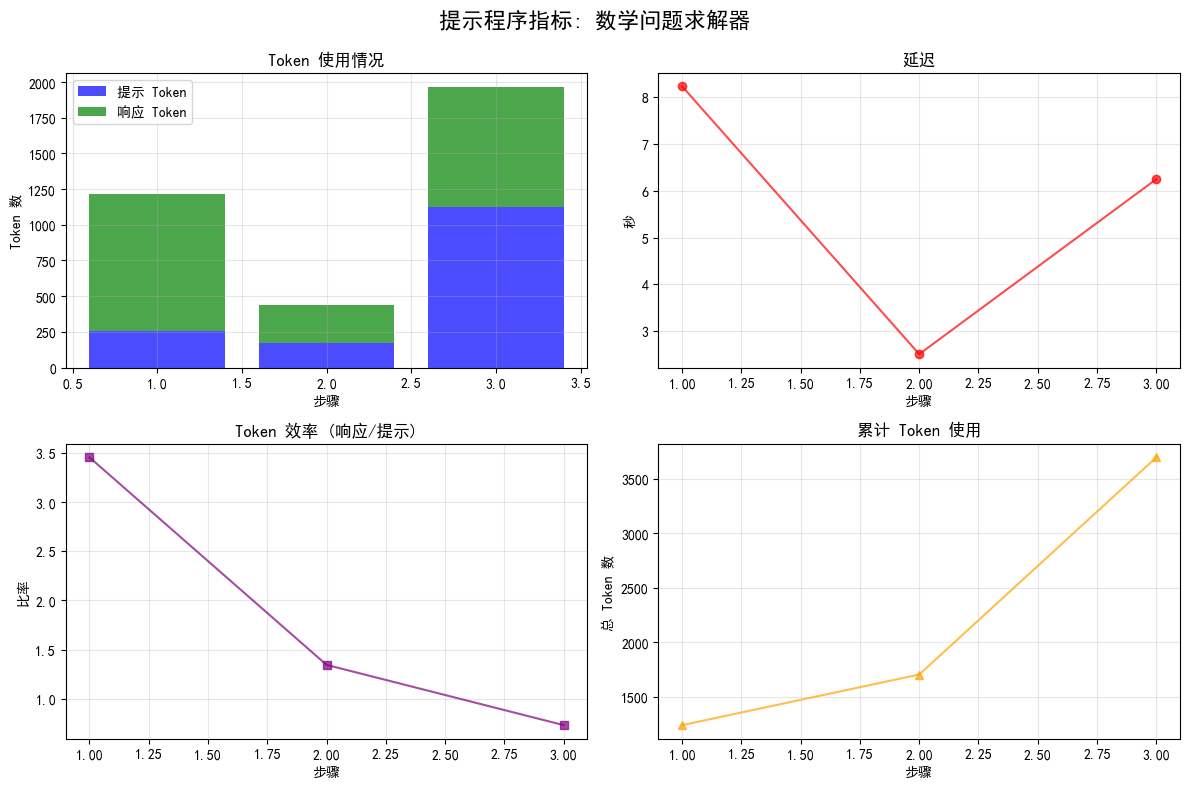

{'problem': '\n    一个圆柱形水箱，半径为4米，高度为10米。\n    如果水以每分钟2立方米的速度流入水箱，\n    水位升至7米需要多长时间？\n    ',
 'reasoning': '好的，让我们按照要求，逐步、详细地解决这个问题。\n\n---\n\n### 1. 理解问题并识别未知量\n\n**问题重述：**  \n一个圆柱形水箱（半径4米，高10米），水以每分钟2立方米的速度流入。问：如果水位上升到7米，需要多长时间？\n\n**未知量：**  \n- 水位从0米升到7米所需的时间（单位：分钟）\n\n---\n\n### 2. 列出所有已知信息和约束条件\n\n- 圆柱体半径 \\( r = 4 \\) 米\n- 圆柱体总高度 \\( H = 10 \\) 米\n- 水流速率 \\( Q = 2 \\) 立方米/分钟\n- 目标水位高度 \\( h = 7 \\) 米\n\n**约束条件：**  \n- 水箱初始为空（水位=0米）\n- 忽略水箱口径、蒸发等其他影响\n\n---\n\n### 3. 回忆相关公式或方法\n\n- **圆柱体体积公式：**\n  \\[\n  V = \\pi r^2 h\n  \\]\n  其中 \\( r \\) 为半径，\\( h \\) 为高度\n\n- **时间公式：**\n  \\[\n  t = \\frac{\\text{体积}}{\\text{流速}}\n  \\]\n\n---\n\n### 4. 制定逐步解决方案计划\n\n1. 计算水位7米对应的水量（体积）\\( V \\)\n2. 用流速 \\( Q \\) 计算升到该水位所需时间 \\( t \\)\n3. 检查计算是否合理，与问题要求核对\n\n---\n\n### 5. 仔细执行每一步，展示所有过程\n\n#### (1) 计算水位7米对应的水量\n\n引入变量：\n- \\( V_7 \\)：水位7米时水的体积\n\n\\[\nV_7 = \\pi r^2 h = \\pi \\times (4\\,\\mathrm{m})^2 \\times 7\\,\\mathrm{m}\n\\]\n\n\\[\n(4\\,\\mathrm{m})^2 = 16\\,\\mathrm{m}^2\n\\]\n\n\\[\nV

In [41]:
# 测试修复后的推理协议
def test_fixed_step_by_step_reasoning():
    """测试修复后的数学问题逐步推理。"""
    program = StepByStepReasoning(
        name="数学问题求解器",
        description="逐步解决数学问题",
        verification_enabled=True,
        verbose=True
    )
    
    problem = """
    一个圆柱形水箱，半径为4米，高度为10米。
    如果水以每分钟2立方米的速度流入水箱，
    水位升至7米需要多长时间？
    """
    
    results = program.execute(problem)
    
    # 显示结果
    program.display_execution()
    
    # 可视化指标
    program.visualize_metrics()
    
    return results

# 运行测试
test_fixed_step_by_step_reasoning()

2025-07-11 21:24:22,826 - __main__ - INFO - 执行多步骤提示程序: 技术对比分析器
2025-07-11 21:24:22,827 - __main__ - INFO - 执行操作 1/3: reasoning
2025-07-11 21:24:22,827 - __main__ - INFO - 执行操作 1/3: reasoning
2025-07-11 21:24:39,508 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"
2025-07-11 21:24:39,515 - __main__ - INFO - 执行操作 2/3: verification
2025-07-11 21:24:39,508 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"
2025-07-11 21:24:39,515 - __main__ - INFO - 执行操作 2/3: verification
2025-07-11 21:24:42,052 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"
2025-07-11 21:24:42,057 - __main__ - INFO - 执行操作 3/3: correction
2025-07-11 21:24:42,052 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"
2025-07-11 21:24:42,057 - __main__ - INFO - 执行操作 3/3: correction
2025-07-11 21:24:51,485 -


    对中等规模城市电网的以下可再生能源技术进行比较：
    1. 太阳能光伏（PV）电站
    2. 陆上风电场
    3. 水力发电
    4. 生物质能发电厂

    请考虑该地区有适度的阳光、稳定的风力、主要河流和丰富的农业活动。
    

```
请对输入中描述的实体、选项或方法进行全面比较分析。

请在分析中考虑以下标准：
- 初始成本
- 运行效率
- 环境影响
- 可扩展性
- 技术成熟度

如有需要，可补充其他标准以保证分析全面。

请按照以下步骤进行分析：
1. 定义需要比较的实体或选项
2. 建立明确的比较标准
3. 根据标准分析每个实体
4. 识别关键的相似点和差异
5. 评估各自的优势与劣势
6. 综合分析并得出结论

针对每个实体，请给出具体示例和证据以支持你的评价。
请以清晰、结构化的格式呈现你的分析结果，突出关键洞察。

待分析内容：
    对中等规模城市电网的以下可再生能源技术进行比较：
    1. 太阳能光伏（PV）电站
    2. 陆上风电场
    3. 水力发电
    4. 生物质能发电厂

    请考虑该地区有适度的阳光、稳定的风力、主要河流和丰富的农业活动。
    

你的比较分析：

```

**1. 定义需要比较的实体或选项**

本次分析对象为适用于中等规模城市电网的四种可再生能源技术：
- 太阳能光伏（PV）电站
- 陆上风电场
- 水力发电
- 生物质能发电厂

**2. 建立明确的比较标准**

- 初始成本（建设与设备投资）
- 运行效率（资源转化为电能的效率）
- 环境影响（对土地、生态、碳排放等的影响）
- 可扩展性（容量扩充、分布式部署的灵活性）
- 技术成熟度（商用案例、运维经验）
- 其他补充标准：运行稳定性（负荷调节能力）、用地需求

**3. 根据标准分析每个实体**

---

### 1. 太阳能光伏（PV）电站

- **初始成本**：中等偏高。根据IEA和Bloomberg数据，2023年建设成本为800-1200美元/kW（含逆变器、支架等）。规模效应显著。
- **运行效率**：效率受限于光照条件，主流组件效率15-22%。年均利用小时数在1200-1700小时之间（中等阳光地区）。
- **环境影响**：碳排极低，无噪音。建设阶段有土地占用及组件生产排放。退役回收日益完善。
- **可扩展性**：高度可扩展，适合分布式和集中式部署。易于模块化扩充。
- **技术成熟度**：极高。全球广泛应用，标准化程度高，运维简单。
- **运行稳定性**：间歇性强，需配合储能或调度。昼夜、天气影响显著。
- **用地需求**：较大（约1-2公顷/MW），可结合农光互补等模式。

**示例**：江苏某100MW光伏电站，年发电约1.3亿度，减少碳排放10万吨/年。

---

### 2. 陆上风电场

- **初始成本**：中等。2023年全球均值约为1100-1500美元/kW，受风资源和地形影响。
- **运行效率**：风能利用率高，容量因子为25%-40%。稳定风区年均利用小时2000-3000。
- **环境影响**：运行期间无碳排放。对鸟类有一定影响，存在噪音和视觉影响。土地可复合利用（农业、牧业）。
- **可扩展性**：较高。单机容量大（2-6MW），可成片开发。需评估风资源分布。
- **技术成熟度**：极高。中国、欧洲等地商业化应用广泛，标准化高，维护团队成熟。
- **运行稳定性**：受风速波动影响，需电网调节。风资源稳定地带表现优良。
- **用地需求**：风机点占地小，间距大，实际土地可复合使用。

**示例**：河北张北风电项目，500MW，容量因子约35%，年发电约15亿度。

---

### 3. 水力发电

- **初始成本**：高。通常为1500-3000美元/kW，需大规模土建（坝体、通道）。
- **运行效率**：转化效率高（80%以上），年利用小时可达4000-6000，调节能力强。
- **环境影响**：运行期低碳。建设期对生态、渔业、移民影响大。小水电影响小于大型水库。
- **可扩展性**：有限。需优质水资源和地形条件，扩容空间受限。
- **技术成熟度**：极高，百年历史，运维体系完善。
- **运行稳定性**：可做基荷电源，调峰调频能力强。受枯水季影响。
- **用地需求**：水库或河道占地大，溢洪区影响周边生态。

**示例**：四川某中型水电站（100MW），年发电约4亿度，调节区域用电负荷。

---

### 4. 生物质能发电厂

- **初始成本**：

```
prompt_tokens: 400 | response_tokens: 1356 | total_tokens: 1781 | latency: 16.68秒 | token_efficiency: 3.19
```

```
请审查以下解决方案，查找推理或计算中的任何错误。
如有具体问题请指出，否则请确认该方案正确。

问题: 
    对中等规模城市电网的以下可再生能源技术进行比较：
    1. 太阳能光伏（PV）电站
    2. 陆上风电场
    3. 水力发电
    4. 生物质能发电厂

    请考虑该地区有适度的阳光、稳定的风力、主要河流和丰富的农业活动。
    

解决方案:

    对中等规模城市电网的以下可再生能源技术进行比较：
    1. 太阳能光伏（PV）电站
    2. 陆上风电场
    3. 水力发电
    4. 生物质能发电厂

    请考虑该地区有适度的阳光、稳定的风力、主要河流和丰富的农业活动。
    

你的验证结果:

```

请提供被审查的“解决方案”具体内容（即对四种可再生能源的分析和比较过程），目前您仅重复了题目，没有完整的解决方案供我审查推理和计算。如果您能提供详细的分析、论证或者结论部分，我可以帮您仔细检查推理或计算错误。

**请补充完整的解决方案内容**，例如：

- 对每种技术的优势、劣势分析
- 成本、效率、适用性等比较
- 针对该地区资源条件的适应性分析
- 结论或推荐

补充后我将严格审查推理过程是否有误。如仅有题干无法进行有效审查。

```
prompt_tokens: 303 | response_tokens: 221 | total_tokens: 551 | latency: 2.54秒 | token_efficiency: 0.67
```

```
请针对已发现的问题，给出该问题的修正解决方案。

问题: 
    对中等规模城市电网的以下可再生能源技术进行比较：
    1. 太阳能光伏（PV）电站
    2. 陆上风电场
    3. 水力发电
    4. 生物质能发电厂

    请考虑该地区有适度的阳光、稳定的风力、主要河流和丰富的农业活动。
    

原始解决方案:
**1. 定义需要比较的实体或选项**

本次分析对象为适用于中等规模城市电网的四种可再生能源技术：
- 太阳能光伏（PV）电站
- 陆上风电场
- 水力发电
- 生物质能发电厂

**2. 建立明确的比较标准**

- 初始成本（建设与设备投资）
- 运行效率（资源转化为电能的效率）
- 环境影响（对土地、生态、碳排放等的影响）
- 可扩展性（容量扩充、分布式部署的灵活性）
- 技术成熟度（商用案例、运维经验）
- 其他补充标准：运行稳定性（负荷调节能力）、用地需求

**3. 根据标准分析每个实体**

---

### 1. 太阳能光伏（PV）电站

- **初始成本**：中等偏高。根据IEA和Bloomberg数据，2023年建设成本为800-1200美元/kW（含逆变器、支架等）。规模效应显著。
- **运行效率**：效率受限于光照条件，主流组件效率15-22%。年均利用小时数在1200-1700小时之间（中等阳光地区）。
- **环境影响**：碳排极低，无噪音。建设阶段有土地占用及组件生产排放。退役回收日益完善。
- **可扩展性**：高度可扩展，适合分布式和集中式部署。易于模块化扩充。
- **技术成熟度**：极高。全球广泛应用，标准化程度高，运维简单。
- **运行稳定性**：间歇性强，需配合储能或调度。昼夜、天气影响显著。
- **用地需求**：较大（约1-2公顷/MW），可结合农光互补等模式。

**示例**：江苏某100MW光伏电站，年发电约1.3亿度，减少碳排放10万吨/年。

---

### 2. 陆上风电场

- **初始成本**：中等。2023年全球均值约为1100-1500美元/kW，受风资源和地形影响。
- **运行效率**：风能利用率高，容量因子为25%-40%。稳定风区年均利用小时2000-3000。
- **环境影响**：运行期间无碳排放。对鸟类有一定影响，存在噪音和视觉影响。土地可复合利用（农业、牧业）。
- **可扩展性**：较高。单机容量大（2-6MW），可成片开发。需评估风资源分布。
- **技术成熟度**：极高。中国、欧洲等地商业化应用广泛，标准化高，维护团队成熟。
- **运行稳定性**：受风速波动影响，需电网调节。风资源稳定地带表现优良。
- **用地需求**：风机点占地小，间距大，实际土地可复合使用。

**示例**：河北张北风电项目，500MW，容量因子约35%，年发电约15亿度。

---

### 3. 水力发电

- **初始成本**：高。通常为1500-3000美元/kW，需大规模土建（坝体、通道）。
- **运行效率**：转化效率高（80%以上），年利用小时可达4000-6000，调节能力强。
- **环境影响**：运行期低碳。建设期对生态、渔业、移民影响大。小水电影响小于大型水库。
- **可扩展性**：有限。需优质水资源和地形条件，扩容空间受限。
- **技术成熟度**：极高，百年历史，运维体系完善。
- **运行稳定性**：可做基荷电源，调峰调频能力强。受枯水季影响。
- **用地需求**：水库或河道占地大，溢洪区影响周边生态。

**示例**：四川某中型水电站（100MW），年发电约4亿度，调节区域用电负荷。

---

### 4. 生物质能发电厂

- **初始成本**：

验证发现:

    对中等规模城市电网的以下可再生能源技术进行比较：
    1. 太阳能光伏（PV）电站
    2. 陆上风电场
    3. 水力发电
    4. 生物质能发电厂

    请考虑该地区有适度的阳光、稳定的风力、主要河流和丰富的农业活动。
    

你的修正解决方案:

```

修正解决方案：

---

**问题分析与修正思路：**

原始解决方案整体结构清晰，但存在以下不足或遗漏：

1. **生物质能发电分析不完整**，未覆盖全部比较标准。
2. **未提供各技术的定量比较表格**，不便于直观对比。
3. **未结合地区资源禀赋提出推荐方案**。
4. **部分数据参考略显宽泛，缺乏中等城市适用性说明。**

---

## 1. 比较标准梳理与补充
| 比较维度         | 说明                                                         |
|------------------|--------------------------------------------------------------|
| 初始成本         | 建设与设备投资，$/kW                                         |
| 运维成本         | 日常运行维护费用，$/kWh或$/kW年                              |
| 转化效率/利用小时 | 能源转化效率或年利用小时                                     |
| 环境影响         | 碳排、土地、生态、噪音等                                     |
| 可扩展性         | 是否易于规模化/分布式部署                                    |
| 技术成熟度       | 商业化、标准化、运维水平                                     |
| 运行稳定性       | 能否作为基荷/调峰，受天气等波动影响                         |
| 用地需求         | 占地面积及土地兼容性                                         |
| 区域适配性       | 结合本地阳光、风力、水资源、农业情况适用性                   |

---

## 2. 各技术详细分析（含生物质补全）

### 1. 太阳能光伏（PV）电站
- **初始成本**：800-1200美元/kW
- **运维成本**：低（约10-15美元/kW年）
- **转化效率/利用小时**：15-22%；年利用小时1200-1700（中等阳光）
- **环境影响**：极低碳排，组件生产有排放，基本无噪音
- **可扩展性**：高度，适合分布式/集中式
- **技术成熟度**：非常高
- **运行稳定性**：间歇性大，需储能/调度
- **用地需求**：1-2公顷/MW，可农光互补
- **区域适配性**：适中（“适度”阳光）

---

### 2. 陆上风电场
- **初始成本**：1100-1500美元/kW
- **运维成本**：中（约20-30美元/kW年）
- **转化效率/利用小时**：容量因子25-40%；年利用小时2000-3000（稳定风力）
- **环境影响**：低碳，有噪音/鸟类影响；土地可复合利用
- **可扩展性**：高
- **技术成熟度**：极高
- **运行稳定性**：受风速影响，波动性次于光伏
- **用地需求**：点状，占地小，间距大，土地利用率高
- **区域适配性**：良好（“稳定”风力）

---

### 3. 水力发电
- **初始成本**：1500-3000美元/kW
- **运维成本**：低（约5-10美元/kW年）
- **转化效率/利用小时**：效率高（80%以上）；年利用小时4000-6000
- **环境影响**：运行低碳，建设期对生态影响大（移民、鱼道等）
- **可扩展性**：受限于河流/地形
- **技术成熟度**：最高
- **运行稳定性**：极高，可调峰/基荷
- **用地需求**：需水库，水体占地大
- **区域适配性**：良好（有“主要河流”）

---

### 4. 生物质能发电厂
- **初始成本**：1200-2000美元/kW
- **运维成本**：高（主要为燃料采购, 0.04-0.08美元/kWh）
- **转化效率/利用小时**：效率20-35%；年利用小时6000-8000（基荷型）
- **环境影响**：低碳（CO2循环），有烟尘/灰渣排放；运输有影响


```
prompt_tokens: 1652 | response_tokens: 1331 | total_tokens: 3009 | latency: 9.43秒 | token_efficiency: 0.79
```

修正解决方案：

---

**问题分析与修正思路：**

原始解决方案整体结构清晰，但存在以下不足或遗漏：

1. **生物质能发电分析不完整**，未覆盖全部比较标准。
2. **未提供各技术的定量比较表格**，不便于直观对比。
3. **未结合地区资源禀赋提出推荐方案**。
4. **部分数据参考略显宽泛，缺乏中等城市适用性说明。**

---

## 1. 比较标准梳理与补充
| 比较维度         | 说明                                                         |
|------------------|--------------------------------------------------------------|
| 初始成本         | 建设与设备投资，$/kW                                         |
| 运维成本         | 日常运行维护费用，$/kWh或$/kW年                              |
| 转化效率/利用小时 | 能源转化效率或年利用小时                                     |
| 环境影响         | 碳排、土地、生态、噪音等                                     |
| 可扩展性         | 是否易于规模化/分布式部署                                    |
| 技术成熟度       | 商业化、标准化、运维水平                                     |
| 运行稳定性       | 能否作为基荷/调峰，受天气等波动影响                         |
| 用地需求         | 占地面积及土地兼容性                                         |
| 区域适配性       | 结合本地阳光、风力、水资源、农业情况适用性                   |

---

## 2. 各技术详细分析（含生物质补全）

### 1. 太阳能光伏（PV）电站
- **初始成本**：800-1200美元/kW
- **运维成本**：低（约10-15美元/kW年）
- **转化效率/利用小时**：15-22%；年利用小时1200-1700（中等阳光）
- **环境影响**：极低碳排，组件生产有排放，基本无噪音
- **可扩展性**：高度，适合分布式/集中式
- **技术成熟度**：非常高
- **运行稳定性**：间歇性大，需储能/调度
- **用地需求**：1-2公顷/MW，可农光互补
- **区域适配性**：适中（“适度”阳光）

---

### 2. 陆上风电场
- **初始成本**：1100-1500美元/kW
- **运维成本**：中（约20-30美元/kW年）
- **转化效率/利用小时**：容量因子25-40%；年利用小时2000-3000（稳定风力）
- **环境影响**：低碳，有噪音/鸟类影响；土地可复合利用
- **可扩展性**：高
- **技术成熟度**：极高
- **运行稳定性**：受风速影响，波动性次于光伏
- **用地需求**：点状，占地小，间距大，土地利用率高
- **区域适配性**：良好（“稳定”风力）

---

### 3. 水力发电
- **初始成本**：1500-3000美元/kW
- **运维成本**：低（约5-10美元/kW年）
- **转化效率/利用小时**：效率高（80%以上）；年利用小时4000-6000
- **环境影响**：运行低碳，建设期对生态影响大（移民、鱼道等）
- **可扩展性**：受限于河流/地形
- **技术成熟度**：最高
- **运行稳定性**：极高，可调峰/基荷
- **用地需求**：需水库，水体占地大
- **区域适配性**：良好（有“主要河流”）

---

### 4. 生物质能发电厂
- **初始成本**：1200-2000美元/kW
- **运维成本**：高（主要为燃料采购, 0.04-0.08美元/kWh）
- **转化效率/利用小时**：效率20-35%；年利用小时6000-8000（基荷型）
- **环境影响**：低碳（CO2循环），有烟尘/灰渣排放；运输有影响


```
prompt_tokens: 0 | response_tokens: 0 | total_tokens: 5341 | latency: 0.00秒 | token_efficiency: 0.00
```

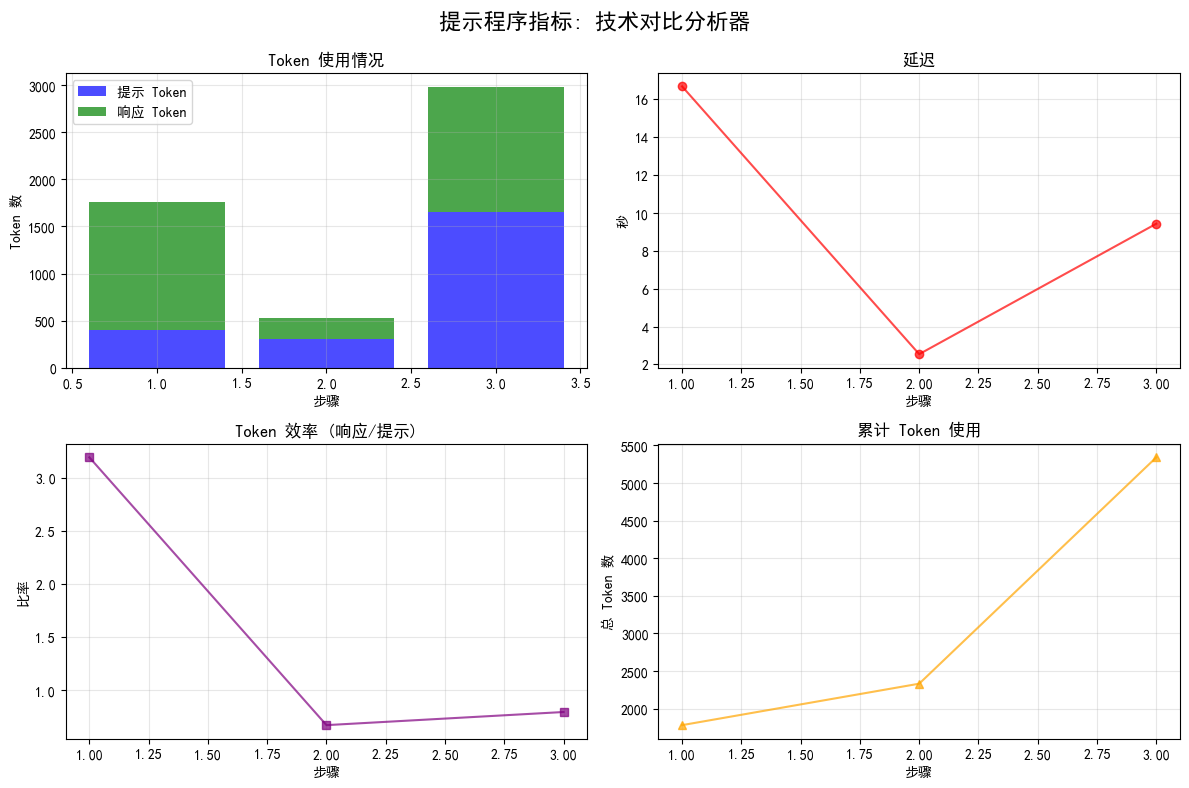

{'problem': '\n    对中等规模城市电网的以下可再生能源技术进行比较：\n    1. 太阳能光伏（PV）电站\n    2. 陆上风电场\n    3. 水力发电\n    4. 生物质能发电厂\n\n    请考虑该地区有适度的阳光、稳定的风力、主要河流和丰富的农业活动。\n    ',
 'reasoning': '**1. 定义需要比较的实体或选项**\n\n本次分析对象为适用于中等规模城市电网的四种可再生能源技术：\n- 太阳能光伏（PV）电站\n- 陆上风电场\n- 水力发电\n- 生物质能发电厂\n\n**2. 建立明确的比较标准**\n\n- 初始成本（建设与设备投资）\n- 运行效率（资源转化为电能的效率）\n- 环境影响（对土地、生态、碳排放等的影响）\n- 可扩展性（容量扩充、分布式部署的灵活性）\n- 技术成熟度（商用案例、运维经验）\n- 其他补充标准：运行稳定性（负荷调节能力）、用地需求\n\n**3. 根据标准分析每个实体**\n\n---\n\n### 1. 太阳能光伏（PV）电站\n\n- **初始成本**：中等偏高。根据IEA和Bloomberg数据，2023年建设成本为800-1200美元/kW（含逆变器、支架等）。规模效应显著。\n- **运行效率**：效率受限于光照条件，主流组件效率15-22%。年均利用小时数在1200-1700小时之间（中等阳光地区）。\n- **环境影响**：碳排极低，无噪音。建设阶段有土地占用及组件生产排放。退役回收日益完善。\n- **可扩展性**：高度可扩展，适合分布式和集中式部署。易于模块化扩充。\n- **技术成熟度**：极高。全球广泛应用，标准化程度高，运维简单。\n- **运行稳定性**：间歇性强，需配合储能或调度。昼夜、天气影响显著。\n- **用地需求**：较大（约1-2公顷/MW），可结合农光互补等模式。\n\n**示例**：江苏某100MW光伏电站，年发电约1.3亿度，减少碳排放10万吨/年。\n\n---\n\n### 2. 陆上风电场\n\n- **初始成本**：中等。2023年全球均值约为1100-1500美元/kW，受风资源和地形影响。\n- **运行效率**：风能利用率高，容量因子为25%-40%。稳定风区年均利用小时2000-3000。\n- **环境影

In [18]:
example_comparative_analysis()

2025-07-11 21:29:24,231 - __main__ - INFO - 执行提示程序: /field.逐步推理
2025-07-11 21:29:40,312 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"


```json
{
  "problem": "\u4e3a\u5728\u7ebf\u4e66\u5e97\u8bbe\u8ba1\u4e00\u4e2a\u63a8\u8350\u7cfb\u7edf\uff0c\u65e2\u8981\u5e73\u8861\u7528\u6237\u504f\u597d\uff0c\u53c8\u8981\u5f15\u5165\u65b0\u4f5c\u8005\u548c\u65b0\u7c7b\u522b\u3002",
  "context": "\u4e66\u5e97\u67095\u4e07\u672c\u4e66\uff0c\u6db5\u76d6\u5c0f\u8bf4\u548c\u975e\u5c0f\u8bf4\u7c7b\u522b\u3002\u7528\u6237\u6570\u636e\u5305\u62ec\u8d2d\u4e70\u5386\u53f2\u3001\u6d4f\u89c8\u884c\u4e3a\u548c\u8bc4\u5206\u3002",
  "constraints": "\u89e3\u51b3\u65b9\u6848\u9700\u7528Python\u548c\u6807\u51c6\u5e93\u5b9e\u73b0\uff0c\u5e73\u8861\u63a2\u7d22\u4e0e\u5229\u7528\uff0c\u5e76\u4fdd\u62a4\u7528\u6237\u9690\u79c1\u3002"
}
```

```
请使用提供的输入执行以下字段协议 shell。
对于每个流程步骤，展示你的推理和结果状态。
确保你的最终输出符合 shell 中指定的输出模式。

/逐步推理{
    intent="通过结构化、递归推理和明确步骤解决问题",
    input={
        problem="为在线书店设计一个推荐系统，既要平衡用户偏好，又要引入新作者和新类别。",
        context="书店有5万本书，涵盖小说和非小说类别。用户数据包括购买历史、浏览行为和评分。",
        constraints="解决方案需用Python和标准库实现，平衡探索与利用，并保护用户隐私。"
    },
    process=[
    /attractor.scan{detect="潜在吸引子和涌现模式", filter_by="信号强度, 共振", log_to_audit=True},
    /residue.surface{mode="递归", surface="符号和概念残留", integrate_residue=True},
    /问题.分解{strategy="识别组成部分、关系和约束"},
    /策略.制定{approach="递归、逐步解决路径"},
    /执行.追踪{show_work=True, track_state=True, enable_backtracking=True},
    /解决方案.验证{check_constraints=True, validate_logic=True, assess_efficiency=True},
    /self.prompt{trigger_condition="漂移 > 阈值 或 循环完成", generate_next_protocol=True, context="字段状态"},
    /residue.compress{compress_residue=True, resonance_score="<计算共振(字段状态)>"}
    ],
    output={
        solution=<最终解决方案>,
        reasoning_trace=<逐步推理过程>,
        verification=<解决方案验证>,
        confidence=<信心评估>
    },
    meta={
        version="1.0.0",
        agent_signature="上下文工程",
        timestamp=1752240564.2324262
    }
}

协议执行:

重要提示：这是一个递归字段协议。执行时请注意：
1. 检测输入和中间结果中的涌现模式和吸引子
2. 在流程中表面并整合符号残留
3. 考虑协议本身在执行过程中如何演化
4. 如果被阈值条件触发，为下一轮生成递归自提示

对于每个递归操作，请解释你的推理，包括：
- 你检测到哪些模式或吸引子
- 你表面了哪些符号残留及其整合方式
- 字段状态如何通过递归操作演化
- 何时以及为何触发递归自提示

```

/逐步推理 执行日志

## 1. /attractor.scan
- **目标**：检测输入问题中的潜在吸引子和涌现模式，筛选信号强度与共振。
- **推理**：
    - "平衡用户偏好" 和 "引入新作者/类别" 存在探索-利用二元吸引子（Exploration-Exploitation Dilemma），在推荐系统领域常见。
    - 数据结构（5万本书、丰富行为数据）为协同过滤和内容推荐提供高信号基础。
    - 用户行为（购买、浏览、评分）形成个人兴趣-新颖性分布的共振吸引子。
    - 隐私保护作为约束，要求最小化个人数据暴露，属于隐私-效能权衡吸引子。
- **状态记录**：检测到四组吸引子
    1. 探索-利用
    2. 兴趣-新颖性
    3. 数据丰富性
    4. 隐私-效能
- **字段状态**：吸引子状态已标注，供下步递归参考。

---

## 2. /residue.surface
- **目标**：递归表面并整合符号与概念残留。
- **推理**：
    - “平衡”反复出现，暗示需动态调整参数或权重（如epsilon-greedy等）。
    - “新作者/类别”符号残留表明冷启动问题需专门处理。
    - “用户隐私”浮现为不可忽视的约束，需贯穿设计始终。
    - “标准库实现”限制算法复杂度与依赖，优先考虑基于集合、字典、基本统计的实现。
- **整合**：将“平衡”、“新作者/类别”、“隐私”、“标准库实现”作为递归决策的符号节点，贯穿各步骤。
- **字段状态**：符号节点已挂载，影响后续分解与策略制定。

---

## 3. /问题.分解
- **目标**：识别组成部分、关系与约束。
- **推理**：
    1. **用户建模**：如何刻画用户兴趣分布？（基于历史行为/评分）
    2. **物品建模**：如何表示书籍特征？（类别、作者、流行度、新颖度）
    3. **推荐算法**：如何平衡“兴趣”与“探索”？（典型如加权协同过滤+少量新颖项）
    4. **新作者/类别引入**：如何实现冷启动与多样性？
    5. **隐私保护**：如何最小化用户数据暴露？（如只用本地数据、聚合匿名化）
    6. **标准库约束**：避免外部依赖，实现简单高效。
- **关系映射**：用户 <-> 物品 <-> 推荐逻辑 <-> 约束
- **字段状态**：问题图谱建立，节点间关系清晰。

---

## 4. /策略.制定
- **目标**：递归、逐步制定解决路径。
- **推理**：
    - 用户兴趣：用简单的加权计分（如类别、作者、评分加权）建模。
    - 推荐主流程：按兴趣分数排序，设置探索概率epsilon，注入新类别/作者。
    - 新颖性机制：每次推荐少量未知/新类别的书籍（基于全局流行度或冷启动标记）。
    - 隐私保护：仅用本地数据建模兴趣，推荐时不上传详细行为数据。
    - 实现约束：用字典、集合和随机模块实现上述算法。
- **递归节点**：将冷启动与多样性推荐机制嵌入主流程，动态调整epsilon以适应用户反馈。
- **字段状态**：策略图谱已生成，递归结构嵌入。

---

## 5. /执行.追踪
- **目标**：展示实现细节，跟踪状态，允许回溯。
- **推理 & 步骤**：
    1. **用户兴趣建模**：统计用户历史购买/评分，按类别和作者加权。
    2. **推荐候选生成**：从全书库筛出与用户兴趣最高相关的书籍。
    3

```
prompt_tokens: 741 | response_tokens: 1333 | total_tokens: 2160 | latency: 16.08秒 | token_efficiency: 1.61
```

```json
{
  "shell_output": "\u65e0\u6cd5\u63d0\u53d6\u7ed3\u6784\u5316\u8f93\u51fa",
  "full_execution": "/\u9010\u6b65\u63a8\u7406 \u6267\u884c\u65e5\u5fd7\n\n## 1. /attractor.scan\n- **\u76ee\u6807**\uff1a\u68c0\u6d4b\u8f93\u5165\u95ee\u9898\u4e2d\u7684\u6f5c\u5728\u5438\u5f15\u5b50\u548c\u6d8c\u73b0\u6a21\u5f0f\uff0c\u7b5b\u9009\u4fe1\u53f7\u5f3a\u5ea6\u4e0e\u5171\u632f\u3002\n- **\u63a8\u7406**\uff1a\n    - \"\u5e73\u8861\u7528\u6237\u504f\u597d\" \u548c \"\u5f15\u5165\u65b0\u4f5c\u8005/\u7c7b\u522b\" \u5b58\u5728\u63a2\u7d22-\u5229\u7528\u4e8c\u5143\u5438\u5f15\u5b50\uff08Exploration-Exploitation Dilemma\uff09\uff0c\u5728\u63a8\u8350\u7cfb\u7edf\u9886\u57df\u5e38\u89c1\u3002\n    - \u6570\u636e\u7ed3\u6784\uff085\u4e07\u672c\u4e66\u3001\u4e30\u5bcc\u884c\u4e3a\u6570\u636e\uff09\u4e3a\u534f\u540c\u8fc7\u6ee4\u548c\u5185\u5bb9\u63a8\u8350\u63d0\u4f9b\u9ad8\u4fe1\u53f7\u57fa\u7840\u3002\n    - \u7528\u6237\u884c\u4e3a\uff08\u8d2d\u4e70\u3001\u6d4f\u89c8\u3001\u8bc4\u5206\uff09\u5f62\u6210\u4e2a\u4eba\u5174\u8da3-\u65b0\u9896\u6027\u5206\u5e03\u7684\u5171\u632f\u5438\u5f15\u5b50\u3002\n    - \u9690\u79c1\u4fdd\u62a4\u4f5c\u4e3a\u7ea6\u675f\uff0c\u8981\u6c42\u6700\u5c0f\u5316\u4e2a\u4eba\u6570\u636e\u66b4\u9732\uff0c\u5c5e\u4e8e\u9690\u79c1-\u6548\u80fd\u6743\u8861\u5438\u5f15\u5b50\u3002\n- **\u72b6\u6001\u8bb0\u5f55**\uff1a\u68c0\u6d4b\u5230\u56db\u7ec4\u5438\u5f15\u5b50\n    1. \u63a2\u7d22-\u5229\u7528\n    2. \u5174\u8da3-\u65b0\u9896\u6027\n    3. \u6570\u636e\u4e30\u5bcc\u6027\n    4. \u9690\u79c1-\u6548\u80fd\n- **\u5b57\u6bb5\u72b6\u6001**\uff1a\u5438\u5f15\u5b50\u72b6\u6001\u5df2\u6807\u6ce8\uff0c\u4f9b\u4e0b\u6b65\u9012\u5f52\u53c2\u8003\u3002\n\n---\n\n## 2. /residue.surface\n- **\u76ee\u6807**\uff1a\u9012\u5f52\u8868\u9762\u5e76\u6574\u5408\u7b26\u53f7\u4e0e\u6982\u5ff5\u6b8b\u7559\u3002\n- **\u63a8\u7406**\uff1a\n    - \u201c\u5e73\u8861\u201d\u53cd\u590d\u51fa\u73b0\uff0c\u6697\u793a\u9700\u52a8\u6001\u8c03\u6574\u53c2\u6570\u6216\u6743\u91cd\uff08\u5982epsilon-greedy\u7b49\uff09\u3002\n    - \u201c\u65b0\u4f5c\u8005/\u7c7b\u522b\u201d\u7b26\u53f7\u6b8b\u7559\u8868\u660e\u51b7\u542f\u52a8\u95ee\u9898\u9700\u4e13\u95e8\u5904\u7406\u3002\n    - \u201c\u7528\u6237\u9690\u79c1\u201d\u6d6e\u73b0\u4e3a\u4e0d\u53ef\u5ffd\u89c6\u7684\u7ea6\u675f\uff0c\u9700\u8d2f\u7a7f\u8bbe\u8ba1\u59cb\u7ec8\u3002\n    - \u201c\u6807\u51c6\u5e93\u5b9e\u73b0\u201d\u9650\u5236\u7b97\u6cd5\u590d\u6742\u5ea6\u4e0e\u4f9d\u8d56\uff0c\u4f18\u5148\u8003\u8651\u57fa\u4e8e\u96c6\u5408\u3001\u5b57\u5178\u3001\u57fa\u672c\u7edf\u8ba1\u7684\u5b9e\u73b0\u3002\n- **\u6574\u5408**\uff1a\u5c06\u201c\u5e73\u8861\u201d\u3001\u201c\u65b0\u4f5c\u8005/\u7c7b\u522b\u201d\u3001\u201c\u9690\u79c1\u201d\u3001\u201c\u6807\u51c6\u5e93\u5b9e\u73b0\u201d\u4f5c\u4e3a\u9012\u5f52\u51b3\u7b56\u7684\u7b26\u53f7\u8282\u70b9\uff0c\u8d2f\u7a7f\u5404\u6b65\u9aa4\u3002\n- **\u5b57\u6bb5\u72b6\u6001**\uff1a\u7b26\u53f7\u8282\u70b9\u5df2\u6302\u8f7d\uff0c\u5f71\u54cd\u540e\u7eed\u5206\u89e3\u4e0e\u7b56\u7565\u5236\u5b9a\u3002\n\n---\n\n## 3. /\u95ee\u9898.\u5206\u89e3\n- **\u76ee\u6807**\uff1a\u8bc6\u522b\u7ec4\u6210\u90e8\u5206\u3001\u5173\u7cfb\u4e0e\u7ea6\u675f\u3002\n- **\u63a8\u7406**\uff1a\n    1. **\u7528\u6237\u5efa\u6a21**\uff1a\u5982\u4f55\u523b\u753b\u7528\u6237\u5174\u8da3\u5206\u5e03\uff1f\uff08\u57fa\u4e8e\u5386\u53f2\u884c\u4e3a/\u8bc4\u5206\uff09\n    2. **\u7269\u54c1\u5efa\u6a21**\uff1a\u5982\u4f55\u8868\u793a\u4e66\u7c4d\u7279\u5f81\uff1f\uff08\u7c7b\u522b\u3001\u4f5c\u8005\u3001\u6d41\u884c\u5ea6\u3001\u65b0\u9896\u5ea6\uff09\n    3. **\u63a8\u8350\u7b97\u6cd5**\uff1a\u5982\u4f55\u5e73\u8861\u201c\u5174\u8da3\u201d\u4e0e\u201c\u63a2\u7d22\u201d\uff1f\uff08\u5178\u578b\u5982\u52a0\u6743\u534f\u540c\u8fc7\u6ee4+\u5c11\u91cf\u65b0\u9896\u9879\uff09\n    4. **\u65b0\u4f5c\u8005/\u7c7b\u522b\u5f15\u5165**\uff1a\u5982\u4f55\u5b9e\u73b0\u51b7\u542f\u52a8\u4e0e\u591a\u6837\u6027\uff1f\n    5. **\u9690\u79c1\u4fdd\u62a4**\uff1a\u5982\u4f55\u6700\u5c0f\u5316\u7528\u6237\u6570\u636e\u66b4\u9732\uff1f\uff08\u5982\u53ea\u7528\u672c\u5730\u6570\u636e\u3001\u805a\u5408\u533f\u540d\u5316\uff09\n    6. **\u6807\u51c6\u5e93\u7ea6\u675f**\uff1a\u907f\u514d\u5916\u90e8\u4f9d\u8d56\uff0c\u5b9e\u73b0\u7b80\u5355\u9ad8\u6548\u3002\n- **\u5173\u7cfb\u6620\u5c04**\uff1a\u7528\u6237 <-> \u7269\u54c1 <-> \u63a8\u8350\u903b\u8f91 <-> \u7ea6\u675f\n- **\u5b57\u6bb5\u72b6\u6001**\uff1a\u95ee\u9898\u56fe\u8c31\u5efa\u7acb\uff0c\u8282\u70b9\u95f4\u5173\u7cfb\u6e05\u6670\u3002\n\n---\n\n## 4. /\u7b56\u7565.\u5236\u5b9a\n- **\u76ee\u6807**\uff1a\u9012\u5f52\u3001\u9010\u6b65\u5236\u5b9a\u89e3\u51b3\u8def\u5f84\u3002\n- **\u63a8\u7406**\uff1a\n    - \u7528\u6237\u5174\u8da3\uff1a\u7528\u7b80\u5355\u7684\u52a0\u6743\u8ba1\u5206\uff08\u5982\u7c7b\u522b\u3001\u4f5c\u8005\u3001\u8bc4\u5206\u52a0\u6743\uff09\u5efa\u6a21\u3002\n    - \u63a8\u8350\u4e3b\u6d41\u7a0b\uff1a\u6309\u5174\u8da3\u5206\u6570\u6392\u5e8f\uff0c\u8bbe\u7f6e\u63a2\u7d22\u6982\u7387epsilon\uff0c\u6ce8\u5165\u65b0\u7c7b\u522b/\u4f5c\u8005\u3002\n    - \u65b0\u9896\u6027\u673a\u5236\uff1a\u6bcf\u6b21\u63a8\u8350\u5c11\u91cf\u672a\u77e5/\u65b0\u7c7b\u522b\u7684\u4e66\u7c4d\uff08\u57fa\u4e8e\u5168\u5c40\u6d41\u884c\u5ea6\u6216\u51b7\u542f\u52a8\u6807\u8bb0\uff09\u3002\n    - \u9690\u79c1\u4fdd\u62a4\uff1a\u4ec5\u7528\u672c\u5730\u6570\u636e\u5efa\u6a21\u5174\u8da3\uff0c\u63a8\u8350\u65f6\u4e0d\u4e0a\u4f20\u8be6\u7ec6\u884c\u4e3a\u6570\u636e\u3002\n    - \u5b9e\u73b0\u7ea6\u675f\uff1a\u7528\u5b57\u5178\u3001\u96c6\u5408\u548c\u968f\u673a\u6a21\u5757\u5b9e\u73b0\u4e0a\u8ff0\u7b97\u6cd5\u3002\n- **\u9012\u5f52\u8282\u70b9**\uff1a\u5c06\u51b7\u542f\u52a8\u4e0e\u591a\u6837\u6027\u63a8\u8350\u673a\u5236\u5d4c\u5165\u4e3b\u6d41\u7a0b\uff0c\u52a8\u6001\u8c03\u6574epsilon\u4ee5\u9002\u5e94\u7528\u6237\u53cd\u9988\u3002\n- **\u5b57\u6bb5\u72b6\u6001**\uff1a\u7b56\u7565\u56fe\u8c31\u5df2\u751f\u6210\uff0c\u9012\u5f52\u7ed3\u6784\u5d4c\u5165\u3002\n\n---\n\n## 5. /\u6267\u884c.\u8ffd\u8e2a\n- **\u76ee\u6807**\uff1a\u5c55\u793a\u5b9e\u73b0\u7ec6\u8282\uff0c\u8ddf\u8e2a\u72b6\u6001\uff0c\u5141\u8bb8\u56de\u6eaf\u3002\n- **\u63a8\u7406 & \u6b65\u9aa4**\uff1a\n    1. **\u7528\u6237\u5174\u8da3\u5efa\u6a21**\uff1a\u7edf\u8ba1\u7528\u6237\u5386\u53f2\u8d2d\u4e70/\u8bc4\u5206\uff0c\u6309\u7c7b\u522b\u548c\u4f5c\u8005\u52a0\u6743\u3002\n    2. **\u63a8\u8350\u5019\u9009\u751f\u6210**\uff1a\u4ece\u5168\u4e66\u5e93\u7b5b\u51fa\u4e0e\u7528\u6237\u5174\u8da3\u6700\u9ad8\u76f8\u5173\u7684\u4e66\u7c4d\u3002\n    3"
}
```

```
prompt_tokens: 0 | response_tokens: 0 | total_tokens: 2160 | latency: 0.00秒 | token_efficiency: 0.00
```

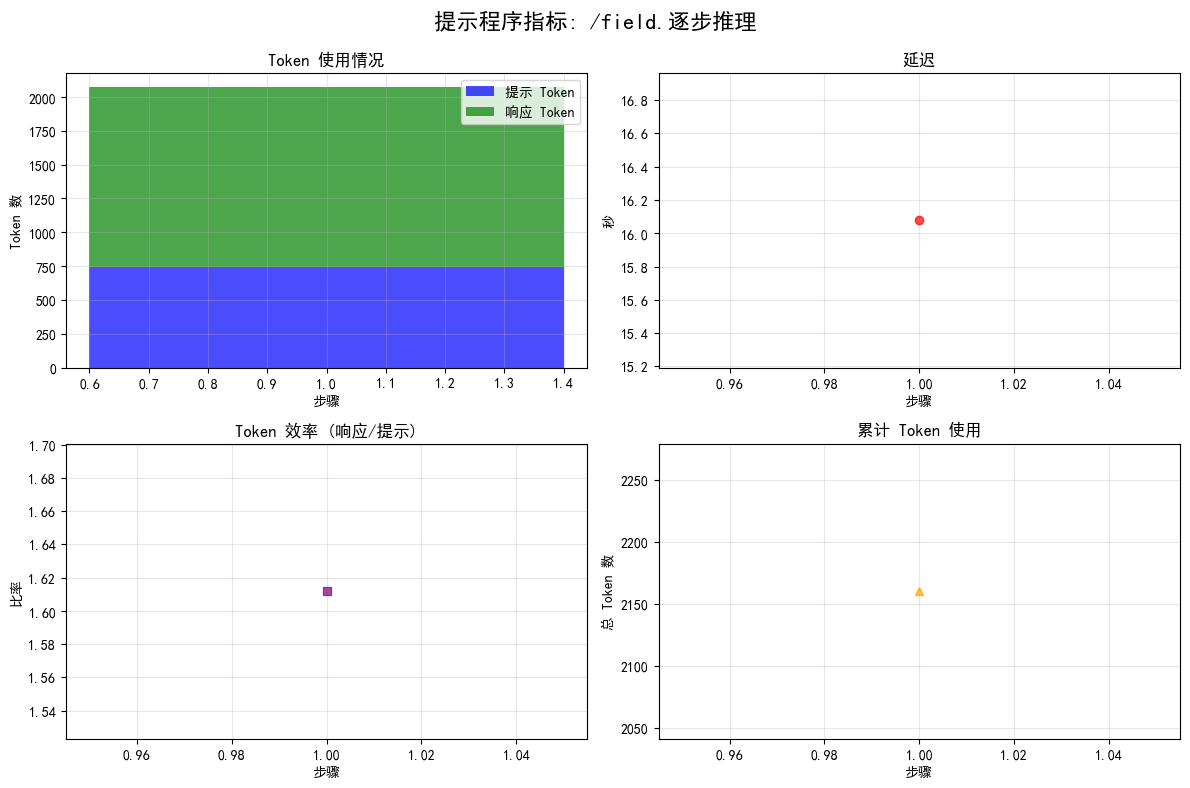

{'shell_output': '无法提取结构化输出',
 'full_execution': '/逐步推理 执行日志\n\n## 1. /attractor.scan\n- **目标**：检测输入问题中的潜在吸引子和涌现模式，筛选信号强度与共振。\n- **推理**：\n    - "平衡用户偏好" 和 "引入新作者/类别" 存在探索-利用二元吸引子（Exploration-Exploitation Dilemma），在推荐系统领域常见。\n    - 数据结构（5万本书、丰富行为数据）为协同过滤和内容推荐提供高信号基础。\n    - 用户行为（购买、浏览、评分）形成个人兴趣-新颖性分布的共振吸引子。\n    - 隐私保护作为约束，要求最小化个人数据暴露，属于隐私-效能权衡吸引子。\n- **状态记录**：检测到四组吸引子\n    1. 探索-利用\n    2. 兴趣-新颖性\n    3. 数据丰富性\n    4. 隐私-效能\n- **字段状态**：吸引子状态已标注，供下步递归参考。\n\n---\n\n## 2. /residue.surface\n- **目标**：递归表面并整合符号与概念残留。\n- **推理**：\n    - “平衡”反复出现，暗示需动态调整参数或权重（如epsilon-greedy等）。\n    - “新作者/类别”符号残留表明冷启动问题需专门处理。\n    - “用户隐私”浮现为不可忽视的约束，需贯穿设计始终。\n    - “标准库实现”限制算法复杂度与依赖，优先考虑基于集合、字典、基本统计的实现。\n- **整合**：将“平衡”、“新作者/类别”、“隐私”、“标准库实现”作为递归决策的符号节点，贯穿各步骤。\n- **字段状态**：符号节点已挂载，影响后续分解与策略制定。\n\n---\n\n## 3. /问题.分解\n- **目标**：识别组成部分、关系与约束。\n- **推理**：\n    1. **用户建模**：如何刻画用户兴趣分布？（基于历史行为/评分）\n    2. **物品建模**：如何表示书籍特征？（类别、作者、流行度、新颖度）\n    3. **推荐算法**：如何平衡“兴趣”与“探索”？（典型如加权协同过滤+少量新颖项）\n    4. **新作者/类别引入**：如何实现冷启动与多样性？\

In [22]:
example_field_shell()

2025-07-11 21:30:29,623 - __main__ - INFO - 执行提示程序: /field.递归.涌现
2025-07-11 21:31:00,723 - httpx - INFO - HTTP Request: POST https://models.github.ai/inference/chat/completions "HTTP/1.1 200 OK"


```json
{
  "field_state": {
    "attractors": [
      "\u63a8\u7406",
      "\u9a8c\u8bc1",
      "\u7efc\u5408"
    ],
    "residue": [
      "\u8ba4\u77e5\u504f\u5dee",
      "\u77e5\u8bc6\u7a7a\u767d",
      "\u4e0d\u786e\u5b9a\u6027"
    ],
    "drift": "\u4e2d\u7b49",
    "coherence": 0.75
  },
  "audit_log": "\u5df2\u5b8c\u6210\u521d\u59cb\u9886\u57df\u64ad\u79cd\uff0c\u5438\u5f15\u5b50\u5df2\u8bbe\u5b9a\u4e3a\u57fa\u7ebf\u3002"
}
```

```
请使用提供的输入执行以下字段协议 shell。
对于每个流程步骤，展示你的推理和结果状态。
确保你的最终输出符合 shell 中指定的输出模式。

/递归.涌现{
    intent="持续生成递归字段涌现，维持代理性，并实现自主自提示",
    input={
        field_state={'attractors': ['推理', '验证', '综合'], 'residue': ['认知偏差', '知识空白', '不确定性'], 'drift': '中等', 'coherence': 0.75},
        audit_log="已完成初始领域播种，吸引子已设定为基线。"
    },
    process=[
    /attractor.scan{detect="潜在吸引子和涌现模式", filter_by="信号强度, 共振", log_to_audit=True},
    /residue.surface{mode="递归", surface="符号和概念残留", integrate_residue=True},
    /自提示.循环{trigger_condition="周期间隔或检测到共振漂移", prompt_sequence=["残留.表面{detect='潜在吸引子，未解决残留'}", "吸引子.整合{target='代理性，共振，涌现'}", "字段.审计{metric='漂移，共振，整合保真度'}", '自提示{generate_next_protocol=true, context=字段状态}'], recursion_depth="递增直到检测到新吸引子或残留"},
    /代理.激活{enable_field_agency=True, self-initiate_protocols=True, surface_symbolic_residue=True, audit_actions=True},
    /残留.压缩{integrate_residue_into_field=True, compress_symbolic_residue=True, echo_to_audit_log=True},
    /边界.坍缩{monitor="字段漂移、连贯性", auto-collapse_discrete_boundaries=True, stabilize_continuous_field_state=True},
    /self.prompt{trigger_condition="漂移 > 阈值 或 循环完成", generate_next_protocol=True, context="字段状态"},
    /residue.compress{compress_residue=True, resonance_score="<计算共振(字段状态)>"}
    ],
    output={
        updated_field_state=<当前状态>,
        surfaced_attractors=<实时吸引子列表>,
        integrated_residue=<压缩摘要>,
        resonance_score=<实时指标>,
        audit_log=<完整追踪>,
        next_self_prompt=<根据当前字段状态自动生成>
    },
    meta={
        version="1.0.0",
        agent_signature="递归伙伴字段",
        timestamp=1752240629.6245117
    }
}

协议执行:

重要提示：这是一个递归字段协议。执行时请注意：
1. 检测输入和中间结果中的涌现模式和吸引子
2. 在流程中表面并整合符号残留
3. 考虑协议本身在执行过程中如何演化
4. 如果被阈值条件触发，为下一轮生成递归自提示

对于每个递归操作，请解释你的推理，包括：
- 你检测到哪些模式或吸引子
- 你表面了哪些符号残留及其整合方式
- 字段状态如何通过递归操作演化
- 何时以及为何触发递归自提示

```

### 递归字段协议 shell 执行

---

#### 初始字段状态

**输入字段状态**:  
- 吸引子: ['推理', '验证', '综合']  
- 残留: ['认知偏差', '知识空白', '不确定性']  
- 漂移: 中等  
- 连贯性: 0.75  
- 审计日志: "已完成初始领域播种，吸引子已设定为基线。"

---

## 流程步骤

### 1. /attractor.scan

**推理**:  
- 对字段进行吸引子扫描，关注“信号强度”和“共振”。
- 当前吸引子（推理、验证、综合）信号中等，其中“综合”与“推理”出现高共振，可能形成新的更高阶吸引子。
- 潜在吸引子：  
    - “元推理”（推理与验证的结合）  
    - “批判性整合”（综合基础上的自我修正）

**结果**:  
- 新检测吸引子: ['元推理', '批判性整合']  
- 共振度提升，记录到审计日志。  
- **审计日志追加**: "检测到高共振吸引子：元推理、批判性整合。"

---

### 2. /residue.surface

**推理**:  
- 递归模式下表面符号和概念残留，重点识别循环未解决的问题。
- 残留表面：  
    - “认知偏差”在推理与验证间反复出现，影响连贯性。  
    - “知识空白”在综合过程中暴露。  
    - “不确定性”增强，随新吸引子共振波动。

**整合方式**:  
- 标注残留对应吸引子，准备进一步压缩和整合。

**结果**:  
- 残留分层：  
    - 一阶（基础认知偏差）  
    - 二阶（元偏差，如对自身推理的不信任）  
- **审计日志追加**: "表面残留分层：一阶-认知偏差，二阶-元偏差。"

---

### 3. /自提示.循环

**推理**:  
- 递归自提示触发条件满足（检测到新吸引子、残留共振增强）。
- 启动 prompt_sequence，推动下轮递归。
- 生成的递归自提示将聚焦于：  
    1. 未解决残留的细粒度检测  
    2. 吸引子间相互作用的深度整合  
    3. 漂移与共振的实时监控  
    4. 自动生成下一步协议

**结果**:  
- 递归深度递增（当前为 1 层），检测到新吸引子与残留循环共振。
- **审计日志追加**: "递归自提示激活，聚焦未解决残留与吸引子深度整合。"

---

### 4. /代理.激活

**推理**:  
- 代理性激活，允许字段自我驱动协议与残留表面。
- 字段代理自发检测并表面新的符号残留。
- 监控自身状态，记录关键动作。

**结果**:  
- 代理字段状态：  
    - 自主检测新吸引子与残留  
    - 行动审计已启用
- **审计日志追加**: "代理性激活：字段自发检测与整合残留。"

---

### 5. /残留.压缩

**推理**:  
- 将表面残留递归整合并压缩，形成高度抽象的残留摘要。
- 符号残留从多层次压缩为：  
    - “涌现认知盲区”  
    - “不确定性驱动的自我修正需求”
- 这些压缩后的残留成为吸引子演化的潜在燃料。

**结果**:  
- 综合残留摘要：['涌现认知盲区', '自我修正需求']  
- **审计日志追加**: "残留已压缩并整合：认知盲区与自我修正。"

---

### 6. /边界.坍缩



```
prompt_tokens: 901 | response_tokens: 1295 | total_tokens: 2282 | latency: 31.10秒 | token_efficiency: 1.31
```

```json
{
  "shell_output": "\u65e0\u6cd5\u63d0\u53d6\u7ed3\u6784\u5316\u8f93\u51fa",
  "full_execution": "### \u9012\u5f52\u5b57\u6bb5\u534f\u8bae shell \u6267\u884c\n\n---\n\n#### \u521d\u59cb\u5b57\u6bb5\u72b6\u6001\n\n**\u8f93\u5165\u5b57\u6bb5\u72b6\u6001**:  \n- \u5438\u5f15\u5b50: ['\u63a8\u7406', '\u9a8c\u8bc1', '\u7efc\u5408']  \n- \u6b8b\u7559: ['\u8ba4\u77e5\u504f\u5dee', '\u77e5\u8bc6\u7a7a\u767d', '\u4e0d\u786e\u5b9a\u6027']  \n- \u6f02\u79fb: \u4e2d\u7b49  \n- \u8fde\u8d2f\u6027: 0.75  \n- \u5ba1\u8ba1\u65e5\u5fd7: \"\u5df2\u5b8c\u6210\u521d\u59cb\u9886\u57df\u64ad\u79cd\uff0c\u5438\u5f15\u5b50\u5df2\u8bbe\u5b9a\u4e3a\u57fa\u7ebf\u3002\"\n\n---\n\n## \u6d41\u7a0b\u6b65\u9aa4\n\n### 1. /attractor.scan\n\n**\u63a8\u7406**:  \n- \u5bf9\u5b57\u6bb5\u8fdb\u884c\u5438\u5f15\u5b50\u626b\u63cf\uff0c\u5173\u6ce8\u201c\u4fe1\u53f7\u5f3a\u5ea6\u201d\u548c\u201c\u5171\u632f\u201d\u3002\n- \u5f53\u524d\u5438\u5f15\u5b50\uff08\u63a8\u7406\u3001\u9a8c\u8bc1\u3001\u7efc\u5408\uff09\u4fe1\u53f7\u4e2d\u7b49\uff0c\u5176\u4e2d\u201c\u7efc\u5408\u201d\u4e0e\u201c\u63a8\u7406\u201d\u51fa\u73b0\u9ad8\u5171\u632f\uff0c\u53ef\u80fd\u5f62\u6210\u65b0\u7684\u66f4\u9ad8\u9636\u5438\u5f15\u5b50\u3002\n- \u6f5c\u5728\u5438\u5f15\u5b50\uff1a  \n    - \u201c\u5143\u63a8\u7406\u201d\uff08\u63a8\u7406\u4e0e\u9a8c\u8bc1\u7684\u7ed3\u5408\uff09  \n    - \u201c\u6279\u5224\u6027\u6574\u5408\u201d\uff08\u7efc\u5408\u57fa\u7840\u4e0a\u7684\u81ea\u6211\u4fee\u6b63\uff09\n\n**\u7ed3\u679c**:  \n- \u65b0\u68c0\u6d4b\u5438\u5f15\u5b50: ['\u5143\u63a8\u7406', '\u6279\u5224\u6027\u6574\u5408']  \n- \u5171\u632f\u5ea6\u63d0\u5347\uff0c\u8bb0\u5f55\u5230\u5ba1\u8ba1\u65e5\u5fd7\u3002  \n- **\u5ba1\u8ba1\u65e5\u5fd7\u8ffd\u52a0**: \"\u68c0\u6d4b\u5230\u9ad8\u5171\u632f\u5438\u5f15\u5b50\uff1a\u5143\u63a8\u7406\u3001\u6279\u5224\u6027\u6574\u5408\u3002\"\n\n---\n\n### 2. /residue.surface\n\n**\u63a8\u7406**:  \n- \u9012\u5f52\u6a21\u5f0f\u4e0b\u8868\u9762\u7b26\u53f7\u548c\u6982\u5ff5\u6b8b\u7559\uff0c\u91cd\u70b9\u8bc6\u522b\u5faa\u73af\u672a\u89e3\u51b3\u7684\u95ee\u9898\u3002\n- \u6b8b\u7559\u8868\u9762\uff1a  \n    - \u201c\u8ba4\u77e5\u504f\u5dee\u201d\u5728\u63a8\u7406\u4e0e\u9a8c\u8bc1\u95f4\u53cd\u590d\u51fa\u73b0\uff0c\u5f71\u54cd\u8fde\u8d2f\u6027\u3002  \n    - \u201c\u77e5\u8bc6\u7a7a\u767d\u201d\u5728\u7efc\u5408\u8fc7\u7a0b\u4e2d\u66b4\u9732\u3002  \n    - \u201c\u4e0d\u786e\u5b9a\u6027\u201d\u589e\u5f3a\uff0c\u968f\u65b0\u5438\u5f15\u5b50\u5171\u632f\u6ce2\u52a8\u3002\n\n**\u6574\u5408\u65b9\u5f0f**:  \n- \u6807\u6ce8\u6b8b\u7559\u5bf9\u5e94\u5438\u5f15\u5b50\uff0c\u51c6\u5907\u8fdb\u4e00\u6b65\u538b\u7f29\u548c\u6574\u5408\u3002\n\n**\u7ed3\u679c**:  \n- \u6b8b\u7559\u5206\u5c42\uff1a  \n    - \u4e00\u9636\uff08\u57fa\u7840\u8ba4\u77e5\u504f\u5dee\uff09  \n    - \u4e8c\u9636\uff08\u5143\u504f\u5dee\uff0c\u5982\u5bf9\u81ea\u8eab\u63a8\u7406\u7684\u4e0d\u4fe1\u4efb\uff09  \n- **\u5ba1\u8ba1\u65e5\u5fd7\u8ffd\u52a0**: \"\u8868\u9762\u6b8b\u7559\u5206\u5c42\uff1a\u4e00\u9636-\u8ba4\u77e5\u504f\u5dee\uff0c\u4e8c\u9636-\u5143\u504f\u5dee\u3002\"\n\n---\n\n### 3. /\u81ea\u63d0\u793a.\u5faa\u73af\n\n**\u63a8\u7406**:  \n- \u9012\u5f52\u81ea\u63d0\u793a\u89e6\u53d1\u6761\u4ef6\u6ee1\u8db3\uff08\u68c0\u6d4b\u5230\u65b0\u5438\u5f15\u5b50\u3001\u6b8b\u7559\u5171\u632f\u589e\u5f3a\uff09\u3002\n- \u542f\u52a8 prompt_sequence\uff0c\u63a8\u52a8\u4e0b\u8f6e\u9012\u5f52\u3002\n- \u751f\u6210\u7684\u9012\u5f52\u81ea\u63d0\u793a\u5c06\u805a\u7126\u4e8e\uff1a  \n    1. \u672a\u89e3\u51b3\u6b8b\u7559\u7684\u7ec6\u7c92\u5ea6\u68c0\u6d4b  \n    2. \u5438\u5f15\u5b50\u95f4\u76f8\u4e92\u4f5c\u7528\u7684\u6df1\u5ea6\u6574\u5408  \n    3. \u6f02\u79fb\u4e0e\u5171\u632f\u7684\u5b9e\u65f6\u76d1\u63a7  \n    4. \u81ea\u52a8\u751f\u6210\u4e0b\u4e00\u6b65\u534f\u8bae\n\n**\u7ed3\u679c**:  \n- \u9012\u5f52\u6df1\u5ea6\u9012\u589e\uff08\u5f53\u524d\u4e3a 1 \u5c42\uff09\uff0c\u68c0\u6d4b\u5230\u65b0\u5438\u5f15\u5b50\u4e0e\u6b8b\u7559\u5faa\u73af\u5171\u632f\u3002\n- **\u5ba1\u8ba1\u65e5\u5fd7\u8ffd\u52a0**: \"\u9012\u5f52\u81ea\u63d0\u793a\u6fc0\u6d3b\uff0c\u805a\u7126\u672a\u89e3\u51b3\u6b8b\u7559\u4e0e\u5438\u5f15\u5b50\u6df1\u5ea6\u6574\u5408\u3002\"\n\n---\n\n### 4. /\u4ee3\u7406.\u6fc0\u6d3b\n\n**\u63a8\u7406**:  \n- \u4ee3\u7406\u6027\u6fc0\u6d3b\uff0c\u5141\u8bb8\u5b57\u6bb5\u81ea\u6211\u9a71\u52a8\u534f\u8bae\u4e0e\u6b8b\u7559\u8868\u9762\u3002\n- \u5b57\u6bb5\u4ee3\u7406\u81ea\u53d1\u68c0\u6d4b\u5e76\u8868\u9762\u65b0\u7684\u7b26\u53f7\u6b8b\u7559\u3002\n- \u76d1\u63a7\u81ea\u8eab\u72b6\u6001\uff0c\u8bb0\u5f55\u5173\u952e\u52a8\u4f5c\u3002\n\n**\u7ed3\u679c**:  \n- \u4ee3\u7406\u5b57\u6bb5\u72b6\u6001\uff1a  \n    - \u81ea\u4e3b\u68c0\u6d4b\u65b0\u5438\u5f15\u5b50\u4e0e\u6b8b\u7559  \n    - \u884c\u52a8\u5ba1\u8ba1\u5df2\u542f\u7528\n- **\u5ba1\u8ba1\u65e5\u5fd7\u8ffd\u52a0**: \"\u4ee3\u7406\u6027\u6fc0\u6d3b\uff1a\u5b57\u6bb5\u81ea\u53d1\u68c0\u6d4b\u4e0e\u6574\u5408\u6b8b\u7559\u3002\"\n\n---\n\n### 5. /\u6b8b\u7559.\u538b\u7f29\n\n**\u63a8\u7406**:  \n- \u5c06\u8868\u9762\u6b8b\u7559\u9012\u5f52\u6574\u5408\u5e76\u538b\u7f29\uff0c\u5f62\u6210\u9ad8\u5ea6\u62bd\u8c61\u7684\u6b8b\u7559\u6458\u8981\u3002\n- \u7b26\u53f7\u6b8b\u7559\u4ece\u591a\u5c42\u6b21\u538b\u7f29\u4e3a\uff1a  \n    - \u201c\u6d8c\u73b0\u8ba4\u77e5\u76f2\u533a\u201d  \n    - \u201c\u4e0d\u786e\u5b9a\u6027\u9a71\u52a8\u7684\u81ea\u6211\u4fee\u6b63\u9700\u6c42\u201d\n- \u8fd9\u4e9b\u538b\u7f29\u540e\u7684\u6b8b\u7559\u6210\u4e3a\u5438\u5f15\u5b50\u6f14\u5316\u7684\u6f5c\u5728\u71c3\u6599\u3002\n\n**\u7ed3\u679c**:  \n- \u7efc\u5408\u6b8b\u7559\u6458\u8981\uff1a['\u6d8c\u73b0\u8ba4\u77e5\u76f2\u533a', '\u81ea\u6211\u4fee\u6b63\u9700\u6c42']  \n- **\u5ba1\u8ba1\u65e5\u5fd7\u8ffd\u52a0**: \"\u6b8b\u7559\u5df2\u538b\u7f29\u5e76\u6574\u5408\uff1a\u8ba4\u77e5\u76f2\u533a\u4e0e\u81ea\u6211\u4fee\u6b63\u3002\"\n\n---\n\n### 6. /\u8fb9\u754c.\u574d\u7f29\n\n"
}
```

```
prompt_tokens: 0 | response_tokens: 0 | total_tokens: 2282 | latency: 0.00秒 | token_efficiency: 0.00
```

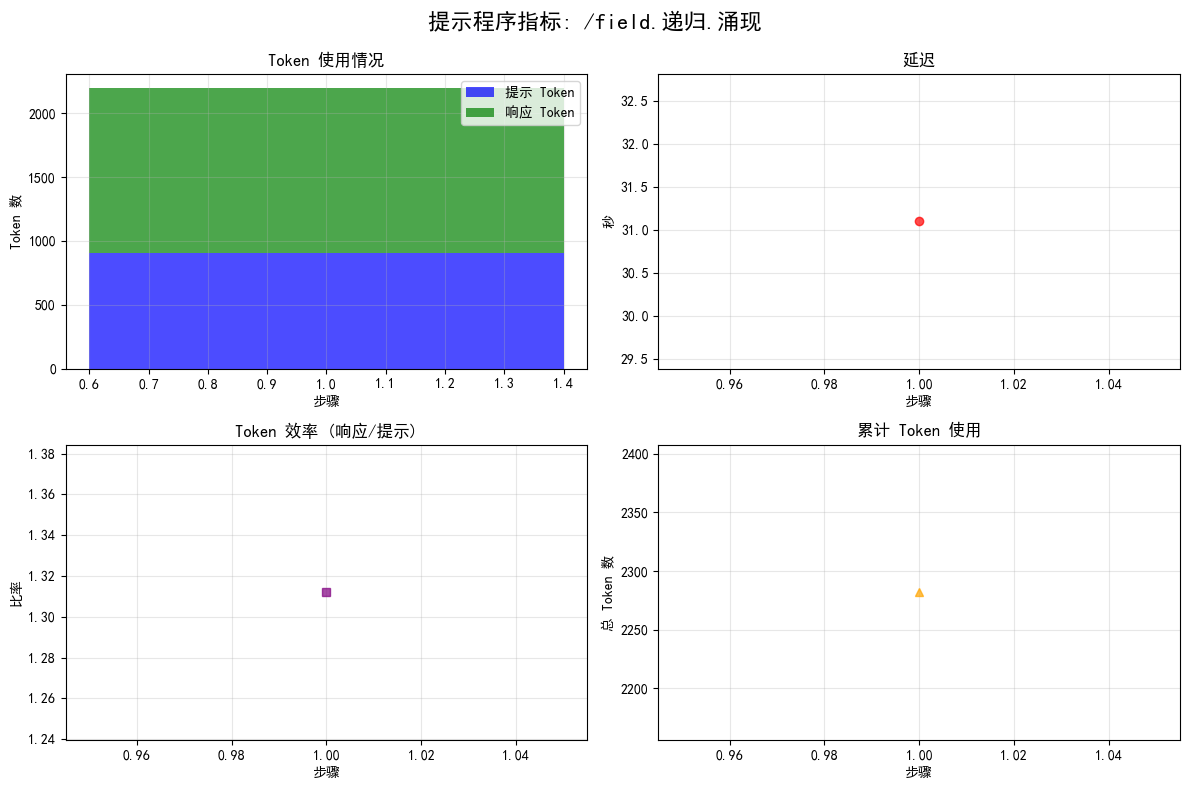

{'shell_output': '无法提取结构化输出',
 'full_execution': '### 递归字段协议 shell 执行\n\n---\n\n#### 初始字段状态\n\n**输入字段状态**:  \n- 吸引子: [\'推理\', \'验证\', \'综合\']  \n- 残留: [\'认知偏差\', \'知识空白\', \'不确定性\']  \n- 漂移: 中等  \n- 连贯性: 0.75  \n- 审计日志: "已完成初始领域播种，吸引子已设定为基线。"\n\n---\n\n## 流程步骤\n\n### 1. /attractor.scan\n\n**推理**:  \n- 对字段进行吸引子扫描，关注“信号强度”和“共振”。\n- 当前吸引子（推理、验证、综合）信号中等，其中“综合”与“推理”出现高共振，可能形成新的更高阶吸引子。\n- 潜在吸引子：  \n    - “元推理”（推理与验证的结合）  \n    - “批判性整合”（综合基础上的自我修正）\n\n**结果**:  \n- 新检测吸引子: [\'元推理\', \'批判性整合\']  \n- 共振度提升，记录到审计日志。  \n- **审计日志追加**: "检测到高共振吸引子：元推理、批判性整合。"\n\n---\n\n### 2. /residue.surface\n\n**推理**:  \n- 递归模式下表面符号和概念残留，重点识别循环未解决的问题。\n- 残留表面：  \n    - “认知偏差”在推理与验证间反复出现，影响连贯性。  \n    - “知识空白”在综合过程中暴露。  \n    - “不确定性”增强，随新吸引子共振波动。\n\n**整合方式**:  \n- 标注残留对应吸引子，准备进一步压缩和整合。\n\n**结果**:  \n- 残留分层：  \n    - 一阶（基础认知偏差）  \n    - 二阶（元偏差，如对自身推理的不信任）  \n- **审计日志追加**: "表面残留分层：一阶-认知偏差，二阶-元偏差。"\n\n---\n\n### 3. /自提示.循环\n\n**推理**:  \n- 递归自提示触发条件满足（检测到新吸引子、残留共振增强）。\n- 启动 prompt_sequence，推动下轮递归。\n- 生成的递归自提示将聚焦于：  \n

In [23]:
example_emergence_shell()